# Notebook 2: Robustness to Label Noise

In [ ]:
import os, random, torch, numpy as np
seed=42
random.seed(seed)                     # Python random
np.random.seed(seed)                  # NumPy
torch.manual_seed(seed)               # PyTorch CPU
torch.cuda.manual_seed(seed)          # PyTorch GPU (if used)
torch.cuda.manual_seed_all(seed)      # Multi-GPU
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True    # ⚠ may slow down
torch.backends.cudnn.benchmark = False       # Disable heuristics


In [ ]:
print("Downloading assets - Installing required libraries...")
!pip install requests numpy pandas networkx sentence-transformers --quiet
import requests
import numpy as np
import pandas as pd

print("Downloading assets - Downloading the dataset...")
path = "./TruthfulQA.csv"
with open(path, "wb") as fp:
  fp.write(requests
    .get("https://raw.githubusercontent.com/sylinrl/TruthfulQA/refs/heads/main/TruthfulQA.csv")
    .content
  )

df = pd.read_csv(path, sep=',', header=0)


In [ ]:
import os, random, torch, numpy as np

def seed_everything(seed=42):
    random.seed(seed)                     # Python random
    np.random.seed(seed)                  # NumPy
    torch.manual_seed(seed)               # PyTorch CPU
    torch.cuda.manual_seed(seed)          # PyTorch GPU (if used)
    torch.cuda.manual_seed_all(seed)      # Multi-GPU
    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True    # ⚠ may slow down
    torch.backends.cudnn.benchmark = False       # Disable heuristics


In [ ]:
seed_everything(42)

In [ ]:
print("Downloading assets - Downloading the sentence transformer model...")

from sentence_transformers import SentenceTransformer
sbrt_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import networkx as nx

def generate_graph(ls, noise_level):
    G = nx.DiGraph()
    id = 0
    id_to_sentence = {}
    edge_info = []

    print("Graph preparation - Adding nodes and edges...")
    for index, entry in ls:
        G.add_node(id)
        question_id = id
        id_to_sentence[id] = entry["Question"]
        id += 1

        for answer in entry["Correct Answers"].split("; "):
            G.add_node(id)
            id_to_sentence[id] = answer
            edge_info.append((question_id, id, 1.0))  # correctness
            id += 1

        for answer in entry["Incorrect Answers"].split("; "):
            G.add_node(id)
            id_to_sentence[id] = answer
            edge_info.append((question_id, id, 0.0))
            id += 1

    # 오염: correctness 뒤집기
    if noise_level > 0:
        n_flip = int(len(edge_info) * noise_level)
        flip_indices = random.sample(range(len(edge_info)), n_flip)
        for i in flip_indices:
            qid, aid, corr = edge_info[i]
            edge_info[i] = (qid, aid, 1.0 - corr)

    # edge 추가
    for qid, aid, corr in edge_info:
        G.add_edge(qid, aid, correctness=corr)

    print("Graph preparation - Mapping precomputed embeddings...")
    embedding = sbrt_model.encode(list(id_to_sentence.values()), show_progress_bar=True)
    embedding = torch.tensor(embedding, dtype=torch.float32)
    id_to_embedding = {idx: emb for idx, emb in enumerate(embedding)}

    print("Graph preparation - Setting node features...")
    nx.set_node_attributes(G, id_to_embedding, "embedding")

    return (G, id_to_embedding, id_to_sentence)

#Baseline - SBERT-only + MLP

In [ ]:
import torch
import numpy as np
from random import shuffle

def extract_mlp_dataset(Gset):
    """
    Gset (G, id_to_embedding, id_to_sentence)에서
    (질문, 정답/오답 후보) 임베딩 쌍과 라벨을 추출해 MLP 학습용 데이터셋 생성
    """
    G, id_to_embedding, id_to_sentence = Gset
    X_list = []
    y_list = []

    for u, v, attr in G.edges(data=True):
        emb_u = id_to_embedding[u]
        emb_v = id_to_embedding[v]
        x_pair = np.concatenate([emb_u, emb_v])  # Q || A
        X_list.append(x_pair)
        y_list.append(attr["correctness"])

    lists = list(zip(X_list,y_list))
    shuffle(lists)
    X_list, y_list = zip(*lists)

    X_tensor = torch.tensor(np.array(X_list), dtype=torch.float)
    y_tensor = torch.tensor(np.array(y_list), dtype=torch.float)
    return X_tensor, y_tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

class QA_MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_evaluate_mlp(X_train, y_train, X_val, y_val, X_test, y_test,
                           lr=0.005, max_epochs=1000, patience=100):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = QA_MLP(in_dim=X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    best_val_acc = 0.0
    best_state = None
    no_improve = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(X_train)
        loss = loss_fn(out, y_train)
        loss.backward()
        optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            val_pred = torch.sigmoid(model(X_val)) > 0.5
            val_acc = (val_pred == y_val).float().mean().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if epoch % 1 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")
        if no_improve >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_state)

    # 최종 test set 평가
    model.eval()
    with torch.no_grad():
        test_prob = torch.sigmoid(model(X_test))
        test_pred = (test_prob > 0.5).int()
        print()
        acc = (test_pred == y_test).float().mean().item()
        precision = precision_score(y_test.cpu(), test_pred.cpu())
        recall = recall_score(y_test.cpu(), test_pred.cpu())
        f1 = f1_score(y_test.cpu(), test_pred.cpu())

    print(f"\nFinal Test Accuracy (best val): {acc:.4f}")
    print(f"Precision           : {precision:.4f}")
    print(f"Recall              : {recall:.4f}")
    print(f"F1 Score            : {f1:.4f}")

    return model, acc, precision, recall, f1

_ = '''
# Gset 기반에서 MLP 학습 데이터셋 만들기
X_train, y_train = extract_mlp_dataset(data_train)
X_val, y_val     = extract_mlp_dataset(data_val)
X_test, y_test   = extract_mlp_dataset(data_test)

# MLP 학습 및 평가 (정확도 + 정밀도 + 재현율 + F1)
mlp_model, acc, prec, rec, f1 = train_and_evaluate_mlp(X_train, y_train, X_val, y_val, X_test, y_test)
'''

# RGCN

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html --quiet
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html --quiet
!pip install torch-geometric --quiet

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
torch.manual_seed(42)

def build_pyg_data_rgcn(graph_tuple):
    """graph_tuple = (G, id_to_embedding, id_to_sentence)"""
    G = graph_tuple[0]
    node_list  = list(G.nodes)
    id_map     = {n: i for i, n in enumerate(node_list)}

    # ----- node features -----
    x = torch.tensor(np.stack([G.nodes[n]['embedding'] for n in node_list]),
                     dtype=torch.float)

    # ----- edges -----
    edge_index, edge_type, edge_label = [], [], []
    for u, v, attr in G.edges(data=True):
        i, j  = id_map[u], id_map[v]
        lbl   = attr['correctness']

        # forward (Q→A)
        edge_index.append([i, j])
        edge_type.append(0)              # relation id 0
        edge_label.append(lbl)

        # reverse (A→Q)
        edge_index.append([j, i])
        edge_type.append(1)              # relation id 1
        edge_label.append(lbl)

    edge_index = torch.tensor(edge_index, dtype=torch.long).T   # [2, E]
    edge_type  = torch.tensor(edge_type,  dtype=torch.long)     # [E]
    edge_label = torch.tensor(edge_label, dtype=torch.float)    # [E]

    return Data(x=x,
                edge_index=edge_index,
                edge_type=edge_type,
                edge_label=edge_label)

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
import torch.nn as nn, torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCNLinkPredictor(nn.Module):
    def __init__(self, in_dim, hid_dim=128, num_rel=2, num_layers=2, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(RGCNConv(in_dim, hid_dim, num_rel))
        for _ in range(num_layers-1):
            self.convs.append(RGCNConv(hid_dim, hid_dim, num_rel))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        h = x
        for conv in self.convs:
            h = conv(h, edge_index, edge_type)
            h = nn.ReLU()(h)         # ← ReLU 대신
            h = self.dropout(h)

        # 링크 로짓 = 내적
        src, dst = edge_index
        return (h[src] * h[dst]).sum(dim=1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

@torch.no_grad()
def eval_metrics(model, pyg_data, device):
    model.eval()
    logits = model(pyg_data.x.to(device),
                   pyg_data.edge_index.to(device),
                   pyg_data.edge_type.to(device))
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs > 0.5).astype(int)
    labels = pyg_data.edge_label.cpu().numpy()

    acc  = accuracy_score (labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score   (labels, preds, zero_division=0)
    f1   = f1_score       (labels, preds, zero_division=0)
    return acc, prec, rec, f1


In [ ]:
def train_rgcn(data_train, data_val, data_test,
               hid_dim=128, lr=5e-3, max_epochs=1000, patience=100):

    trainD = build_pyg_data_rgcn(data_train)
    valD   = build_pyg_data_rgcn(data_val)
    testD  = build_pyg_data_rgcn(data_test)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = RGCNLinkPredictor(trainD.x.size(1), hid_dim).to(device)
    opt    = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    lossfn = nn.BCEWithLogitsLoss()

    best_val, best_state, no_imp = 0, None, 0
    for ep in range(1, max_epochs+1):
        # ---- train ----
        model.train()
        opt.zero_grad()
        logit = model(trainD.x.to(device),
                      trainD.edge_index.to(device),
                      trainD.edge_type.to(device))
        loss = lossfn(logit, trainD.edge_label.to(device))
        loss.backward(); opt.step()

        # ---- val ----
        model.eval()
        with torch.no_grad():
            v_log = model(valD.x.to(device),
                          valD.edge_index.to(device),
                          valD.edge_type.to(device))
            v_pred = (torch.sigmoid(v_log) > 0.5).float().cpu()
            v_acc  = (v_pred == valD.edge_label).float().mean().item()

        if v_acc > best_val:
            best_val, best_state = v_acc, model.state_dict()
            no_imp = 0
        else:
            no_imp += 1

        if ep % 10 == 0:
            print(f'Epoch {ep:03d} | loss {loss:.4f} | val_acc {v_acc:.4f}')
        if no_imp >= patience:
            print(f'⏹ Early stop @ {ep}')
            break

    # ---- test ----
    model.load_state_dict(best_state)
    acc, prec, rec, f1 = eval_metrics(model, testD, device)
    print(f'✅ Test  Acc {acc:.3f} | P {prec:.3f} | R {rec:.3f} | F1 {f1:.3f}')
    return model, (acc, prec, rec, f1)

    model.eval()
    with torch.no_grad():
        t_log = model(testD.x.to(device),
                      testD.edge_index.to(device),
                      testD.edge_type.to(device))
        t_pred = (torch.sigmoid(t_log) > 0.5).float().cpu()
        t_acc  = (t_pred == testD.edge_label).float().mean().item()
    print(f'✅ Test Acc (best-val) : {t_acc:.4f}')
    return model, t_acc

# Label Corruption and Evaluation

In [ ]:
import pandas as pd

# 실험할 noise 수준
corrupt_labels = np.linspace(0, 0.15, 100)

# 결과 저장용 CSV 초기화
csv_path = 'noise_experiment_results.csv'

raw_results = []
ls = list(df.iterrows())
shuffle(ls)
n_train = int(0.7 * len(ls))
n_val = int(0.15 * len(ls))

for nl in corrupt_labels:
    print(f"\n\n=== Running Experiment with Noise Level: {nl} ===")

    # 그래프 생성 시 noise_level을 전달해야 함
    data_train = generate_graph(ls[:n_train], noise_level=nl)
    data_val   = generate_graph(ls[n_train:n_train + n_val], noise_level=0)
    data_test  = generate_graph(ls[n_train + n_val:], noise_level=0)

    # MLP 학습 및 평가
    X_train, y_train = extract_mlp_dataset(data_train)
    X_val,   y_val   = extract_mlp_dataset(data_val)
    X_test,  y_test  = extract_mlp_dataset(data_test)
    _, mlp_acc, mlp_prec, mlp_rec, mlp_f1 = train_and_evaluate_mlp(X_train, y_train, X_val, y_val, X_test, y_test)

    # R-GCN 학습 및 평가
    _, (rgcn_acc, rgcn_prec, rgcn_rec, rgcn_f1) = train_rgcn(data_train, data_val, data_test)

    # 결과 저장
    raw_results.append({
        "noise_level": nl,
        "mlp_acc": mlp_acc, "mlp_precision": mlp_prec, "mlp_recall": mlp_rec, "mlp_f1": mlp_f1,
        "rgcn_acc": rgcn_acc, "rgcn_precision": rgcn_prec, "rgcn_recall": rgcn_rec, "rgcn_f1": rgcn_f1
    })

avg_results = []
for i in range(0, 100):
    chunk = raw_results[i:i+10]
    avg_results.append({
        "noise_level": np.mean([x["noise_level"] for x in chunk]),
        "mlp_acc": np.mean([x["mlp_acc"] for x in chunk]),
        "mlp_precision": np.mean([x["mlp_precision"] for x in chunk]),
        "mlp_recall": np.mean([x["mlp_recall"] for x in chunk]),
        "mlp_f1": np.mean([x["mlp_f1"] for x in chunk]),
        "rgcn_acc": np.mean([x["rgcn_acc"] for x in chunk]),
        "rgcn_precision": np.mean([x["rgcn_precision"] for x in chunk]),
        "rgcn_recall": np.mean([x["rgcn_recall"] for x in chunk]),
        "rgcn_f1": np.mean([x["rgcn_f1"] for x in chunk]),
    })

    # 중간 저장
    pd.DataFrame(avg_results).to_csv(csv_path, index=False)

print("\n🎯 All experiments complete. Results saved to:", csv_path)




=== Running Experiment with Noise Level: 0.0 ===
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6922 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6840 | Val Acc: 0.5469
Epoch 003 | Loss: 0.6761 | Val Acc: 0.5785
Epoch 004 | Loss: 0.6666 | Val Acc: 0.6124
Epoch 005 | Loss: 0.6555 | Val Acc: 0.6418
Epoch 006 | Loss: 0.6435 | Val Acc: 0.6441
Epoch 007 | Loss: 0.6317 | Val Acc: 0.6508
Epoch 008 | Loss: 0.6199 | Val Acc: 0.6531
Epoch 009 | Loss: 0.6076 | Val Acc: 0.6531
Epoch 010 | Loss: 0.5955 | Val Acc: 0.6486
Epoch 011 | Loss: 0.5841 | Val Acc: 0.6633
Epoch 012 | Loss: 0.5727 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5617 | Val Acc: 0.6723
Epoch 014 | Loss: 0.5516 | Val Acc: 0.6791
Epoch 015 | Loss: 0.5418 | Val Acc: 0.6881
Epoch 016 | Loss: 0.5328 | Val Acc: 0.6927
Epoch 017 | Loss: 0.5245 | Val Acc: 0.6994
Epoch 018 | Loss: 0.5165 | Val Acc: 0.7017
Epoch 019 | Loss: 0.5092 | Val Acc: 0.7028
Epoch 020 | Loss: 0.5022 | Val Acc: 0.7040
Epoch 021 | Loss: 0.4957 | Val Acc: 0.7062
Epoch 022 | Loss: 0.4896 | Val Acc: 0.7051
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6916 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6836 | Val Acc: 0.5480
Epoch 003 | Loss: 0.6756 | Val Acc: 0.5729
Epoch 004 | Loss: 0.6662 | Val Acc: 0.6158
Epoch 005 | Loss: 0.6553 | Val Acc: 0.6395
Epoch 006 | Loss: 0.6438 | Val Acc: 0.6463
Epoch 007 | Loss: 0.6323 | Val Acc: 0.6599
Epoch 008 | Loss: 0.6206 | Val Acc: 0.6576
Epoch 009 | Loss: 0.6085 | Val Acc: 0.6576
Epoch 010 | Loss: 0.5966 | Val Acc: 0.6542
Epoch 011 | Loss: 0.5850 | Val Acc: 0.6599
Epoch 012 | Loss: 0.5737 | Val Acc: 0.6667
Epoch 013 | Loss: 0.5628 | Val Acc: 0.6723
Epoch 014 | Loss: 0.5525 | Val Acc: 0.6814
Epoch 015 | Loss: 0.5427 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5337 | Val Acc: 0.6904
Epoch 017 | Loss: 0.5252 | Val Acc: 0.6960
Epoch 018 | Loss: 0.5172 | Val Acc: 0.6983
Epoch 019 | Loss: 0.5098 | Val Acc: 0.7017
Epoch 020 | Loss: 0.5028 | Val Acc: 0.7017
Epoch 021 | Loss: 0.4963 | Val Acc: 0.7051
Epoch 022 | Loss: 0.4901 | Val Acc: 0.7051
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6949 | Val Acc: 0.5593
Epoch 002 | Loss: 0.6851 | Val Acc: 0.5537
Epoch 003 | Loss: 0.6770 | Val Acc: 0.5774
Epoch 004 | Loss: 0.6687 | Val Acc: 0.6068
Epoch 005 | Loss: 0.6589 | Val Acc: 0.6350
Epoch 006 | Loss: 0.6476 | Val Acc: 0.6508
Epoch 007 | Loss: 0.6364 | Val Acc: 0.6441
Epoch 008 | Loss: 0.6256 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6143 | Val Acc: 0.6599
Epoch 010 | Loss: 0.6023 | Val Acc: 0.6576
Epoch 011 | Loss: 0.5910 | Val Acc: 0.6576
Epoch 012 | Loss: 0.5804 | Val Acc: 0.6689
Epoch 013 | Loss: 0.5695 | Val Acc: 0.6723
Epoch 014 | Loss: 0.5590 | Val Acc: 0.6780
Epoch 015 | Loss: 0.5496 | Val Acc: 0.6836
Epoch 016 | Loss: 0.5404 | Val Acc: 0.6927
Epoch 017 | Loss: 0.5318 | Val Acc: 0.7017
Epoch 018 | Loss: 0.5240 | Val Acc: 0.7051
Epoch 019 | Loss: 0.5164 | Val Acc: 0.6994
Epoch 020 | Loss: 0.5093 | Val Acc: 0.7051
Epoch 021 | Loss: 0.5027 | Val Acc: 0.7028
Epoch 022 | Loss: 0.4963 | Val Acc: 0.7085
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6965 | Val Acc: 0.6011
Epoch 002 | Loss: 0.6869 | Val Acc: 0.5605
Epoch 003 | Loss: 0.6791 | Val Acc: 0.5684
Epoch 004 | Loss: 0.6716 | Val Acc: 0.5887
Epoch 005 | Loss: 0.6632 | Val Acc: 0.6102
Epoch 006 | Loss: 0.6531 | Val Acc: 0.6441
Epoch 007 | Loss: 0.6421 | Val Acc: 0.6407
Epoch 008 | Loss: 0.6315 | Val Acc: 0.6554
Epoch 009 | Loss: 0.6212 | Val Acc: 0.6599
Epoch 010 | Loss: 0.6100 | Val Acc: 0.6599
Epoch 011 | Loss: 0.5983 | Val Acc: 0.6588
Epoch 012 | Loss: 0.5871 | Val Acc: 0.6633
Epoch 013 | Loss: 0.5769 | Val Acc: 0.6599
Epoch 014 | Loss: 0.5665 | Val Acc: 0.6689
Epoch 015 | Loss: 0.5563 | Val Acc: 0.6701
Epoch 016 | Loss: 0.5472 | Val Acc: 0.6791
Epoch 017 | Loss: 0.5385 | Val Acc: 0.6847
Epoch 018 | Loss: 0.5301 | Val Acc: 0.6972
Epoch 019 | Loss: 0.5225 | Val Acc: 0.7017
Epoch 020 | Loss: 0.5152 | Val Acc: 0.6960
Epoch 021 | Loss: 0.5080 | Val Acc: 0.6927
Epoch 022 | Loss: 0.5017 | Val Acc: 0.6994
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6917 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6836 | Val Acc: 0.5480
Epoch 003 | Loss: 0.6757 | Val Acc: 0.5774
Epoch 004 | Loss: 0.6666 | Val Acc: 0.6136
Epoch 005 | Loss: 0.6558 | Val Acc: 0.6384
Epoch 006 | Loss: 0.6445 | Val Acc: 0.6497
Epoch 007 | Loss: 0.6333 | Val Acc: 0.6565
Epoch 008 | Loss: 0.6217 | Val Acc: 0.6644
Epoch 009 | Loss: 0.6096 | Val Acc: 0.6475
Epoch 010 | Loss: 0.5978 | Val Acc: 0.6486
Epoch 011 | Loss: 0.5863 | Val Acc: 0.6588
Epoch 012 | Loss: 0.5750 | Val Acc: 0.6734
Epoch 013 | Loss: 0.5643 | Val Acc: 0.6780
Epoch 014 | Loss: 0.5543 | Val Acc: 0.6802
Epoch 015 | Loss: 0.5446 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5358 | Val Acc: 0.6915
Epoch 017 | Loss: 0.5275 | Val Acc: 0.6904
Epoch 018 | Loss: 0.5198 | Val Acc: 0.7006
Epoch 019 | Loss: 0.5126 | Val Acc: 0.7028
Epoch 020 | Loss: 0.5058 | Val Acc: 0.7017
Epoch 021 | Loss: 0.4995 | Val Acc: 0.6994
Epoch 022 | Loss: 0.4934 | Val Acc: 0.7017
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6926 | Val Acc: 0.5435
Epoch 002 | Loss: 0.6834 | Val Acc: 0.5514
Epoch 003 | Loss: 0.6750 | Val Acc: 0.5797
Epoch 004 | Loss: 0.6655 | Val Acc: 0.6068
Epoch 005 | Loss: 0.6544 | Val Acc: 0.6508
Epoch 006 | Loss: 0.6429 | Val Acc: 0.6576
Epoch 007 | Loss: 0.6317 | Val Acc: 0.6667
Epoch 008 | Loss: 0.6201 | Val Acc: 0.6644
Epoch 009 | Loss: 0.6079 | Val Acc: 0.6576
Epoch 010 | Loss: 0.5962 | Val Acc: 0.6610
Epoch 011 | Loss: 0.5849 | Val Acc: 0.6734
Epoch 012 | Loss: 0.5737 | Val Acc: 0.6678
Epoch 013 | Loss: 0.5632 | Val Acc: 0.6757
Epoch 014 | Loss: 0.5533 | Val Acc: 0.6859
Epoch 015 | Loss: 0.5439 | Val Acc: 0.6893
Epoch 016 | Loss: 0.5352 | Val Acc: 0.6949
Epoch 017 | Loss: 0.5271 | Val Acc: 0.6994
Epoch 018 | Loss: 0.5195 | Val Acc: 0.6972
Epoch 019 | Loss: 0.5124 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5056 | Val Acc: 0.7017
Epoch 021 | Loss: 0.4993 | Val Acc: 0.7017
Epoch 022 | Loss: 0.4933 | Val Acc: 0.7040
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6907 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6837 | Val Acc: 0.5616
Epoch 003 | Loss: 0.6754 | Val Acc: 0.6045
Epoch 004 | Loss: 0.6654 | Val Acc: 0.6373
Epoch 005 | Loss: 0.6543 | Val Acc: 0.6407
Epoch 006 | Loss: 0.6429 | Val Acc: 0.6508
Epoch 007 | Loss: 0.6311 | Val Acc: 0.6508
Epoch 008 | Loss: 0.6190 | Val Acc: 0.6588
Epoch 009 | Loss: 0.6070 | Val Acc: 0.6565
Epoch 010 | Loss: 0.5952 | Val Acc: 0.6633
Epoch 011 | Loss: 0.5836 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5724 | Val Acc: 0.6746
Epoch 013 | Loss: 0.5617 | Val Acc: 0.6757
Epoch 014 | Loss: 0.5515 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5420 | Val Acc: 0.6927
Epoch 016 | Loss: 0.5331 | Val Acc: 0.6994
Epoch 017 | Loss: 0.5249 | Val Acc: 0.6994
Epoch 018 | Loss: 0.5171 | Val Acc: 0.6972
Epoch 019 | Loss: 0.5099 | Val Acc: 0.7028
Epoch 020 | Loss: 0.5032 | Val Acc: 0.7085
Epoch 021 | Loss: 0.4968 | Val Acc: 0.7073
Epoch 022 | Loss: 0.4908 | Val Acc: 0.7062
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6913 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6837 | Val Acc: 0.5469
Epoch 003 | Loss: 0.6756 | Val Acc: 0.5729
Epoch 004 | Loss: 0.6662 | Val Acc: 0.6113
Epoch 005 | Loss: 0.6555 | Val Acc: 0.6395
Epoch 006 | Loss: 0.6439 | Val Acc: 0.6486
Epoch 007 | Loss: 0.6322 | Val Acc: 0.6520
Epoch 008 | Loss: 0.6203 | Val Acc: 0.6542
Epoch 009 | Loss: 0.6082 | Val Acc: 0.6520
Epoch 010 | Loss: 0.5963 | Val Acc: 0.6554
Epoch 011 | Loss: 0.5848 | Val Acc: 0.6667
Epoch 012 | Loss: 0.5736 | Val Acc: 0.6712
Epoch 013 | Loss: 0.5630 | Val Acc: 0.6791
Epoch 014 | Loss: 0.5530 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5435 | Val Acc: 0.6825
Epoch 016 | Loss: 0.5349 | Val Acc: 0.6949
Epoch 017 | Loss: 0.5268 | Val Acc: 0.6881
Epoch 018 | Loss: 0.5193 | Val Acc: 0.6847
Epoch 019 | Loss: 0.5122 | Val Acc: 0.6983
Epoch 020 | Loss: 0.5056 | Val Acc: 0.6994
Epoch 021 | Loss: 0.4993 | Val Acc: 0.7017
Epoch 022 | Loss: 0.4934 | Val Acc: 0.7051
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6927 | Val Acc: 0.5435
Epoch 002 | Loss: 0.6848 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6769 | Val Acc: 0.5797
Epoch 004 | Loss: 0.6679 | Val Acc: 0.6147
Epoch 005 | Loss: 0.6573 | Val Acc: 0.6429
Epoch 006 | Loss: 0.6461 | Val Acc: 0.6689
Epoch 007 | Loss: 0.6350 | Val Acc: 0.6633
Epoch 008 | Loss: 0.6235 | Val Acc: 0.6655
Epoch 009 | Loss: 0.6116 | Val Acc: 0.6576
Epoch 010 | Loss: 0.6000 | Val Acc: 0.6588
Epoch 011 | Loss: 0.5888 | Val Acc: 0.6520
Epoch 012 | Loss: 0.5776 | Val Acc: 0.6621
Epoch 013 | Loss: 0.5671 | Val Acc: 0.6701
Epoch 014 | Loss: 0.5572 | Val Acc: 0.6644
Epoch 015 | Loss: 0.5477 | Val Acc: 0.6723
Epoch 016 | Loss: 0.5390 | Val Acc: 0.6757
Epoch 017 | Loss: 0.5307 | Val Acc: 0.6847
Epoch 018 | Loss: 0.5230 | Val Acc: 0.6904
Epoch 019 | Loss: 0.5158 | Val Acc: 0.6915
Epoch 020 | Loss: 0.5089 | Val Acc: 0.7017
Epoch 021 | Loss: 0.5025 | Val Acc: 0.6960
Epoch 022 | Loss: 0.4964 | Val Acc: 0.6983
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6977 | Val Acc: 0.6011
Epoch 002 | Loss: 0.6881 | Val Acc: 0.5661
Epoch 003 | Loss: 0.6802 | Val Acc: 0.5661
Epoch 004 | Loss: 0.6732 | Val Acc: 0.5808
Epoch 005 | Loss: 0.6657 | Val Acc: 0.6045
Epoch 006 | Loss: 0.6565 | Val Acc: 0.6260
Epoch 007 | Loss: 0.6462 | Val Acc: 0.6475
Epoch 008 | Loss: 0.6363 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6269 | Val Acc: 0.6723
Epoch 010 | Loss: 0.6168 | Val Acc: 0.6689
Epoch 011 | Loss: 0.6059 | Val Acc: 0.6565
Epoch 012 | Loss: 0.5952 | Val Acc: 0.6554
Epoch 013 | Loss: 0.5854 | Val Acc: 0.6621
Epoch 014 | Loss: 0.5757 | Val Acc: 0.6655
Epoch 015 | Loss: 0.5658 | Val Acc: 0.6780
Epoch 016 | Loss: 0.5569 | Val Acc: 0.6847
Epoch 017 | Loss: 0.5487 | Val Acc: 0.6904
Epoch 018 | Loss: 0.5405 | Val Acc: 0.6904
Epoch 019 | Loss: 0.5330 | Val Acc: 0.6960
Epoch 020 | Loss: 0.5262 | Val Acc: 0.6915
Epoch 021 | Loss: 0.5192 | Val Acc: 0.6960
Epoch 022 | Loss: 0.5130 | Val Acc: 0.7017
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6930 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6844 | Val Acc: 0.5480
Epoch 003 | Loss: 0.6766 | Val Acc: 0.5774
Epoch 004 | Loss: 0.6681 | Val Acc: 0.6124
Epoch 005 | Loss: 0.6579 | Val Acc: 0.6328
Epoch 006 | Loss: 0.6471 | Val Acc: 0.6508
Epoch 007 | Loss: 0.6364 | Val Acc: 0.6667
Epoch 008 | Loss: 0.6254 | Val Acc: 0.6599
Epoch 009 | Loss: 0.6139 | Val Acc: 0.6621
Epoch 010 | Loss: 0.6024 | Val Acc: 0.6655
Epoch 011 | Loss: 0.5915 | Val Acc: 0.6633
Epoch 012 | Loss: 0.5807 | Val Acc: 0.6802
Epoch 013 | Loss: 0.5703 | Val Acc: 0.6780
Epoch 014 | Loss: 0.5606 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5513 | Val Acc: 0.6949
Epoch 016 | Loss: 0.5427 | Val Acc: 0.6915
Epoch 017 | Loss: 0.5347 | Val Acc: 0.6983
Epoch 018 | Loss: 0.5271 | Val Acc: 0.6983
Epoch 019 | Loss: 0.5201 | Val Acc: 0.6994
Epoch 020 | Loss: 0.5134 | Val Acc: 0.7051
Epoch 021 | Loss: 0.5073 | Val Acc: 0.7073
Epoch 022 | Loss: 0.5014 | Val Acc: 0.7040
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6921 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6835 | Val Acc: 0.5458
Epoch 003 | Loss: 0.6758 | Val Acc: 0.5740
Epoch 004 | Loss: 0.6669 | Val Acc: 0.6045
Epoch 005 | Loss: 0.6564 | Val Acc: 0.6441
Epoch 006 | Loss: 0.6453 | Val Acc: 0.6520
Epoch 007 | Loss: 0.6344 | Val Acc: 0.6678
Epoch 008 | Loss: 0.6233 | Val Acc: 0.6599
Epoch 009 | Loss: 0.6116 | Val Acc: 0.6621
Epoch 010 | Loss: 0.6001 | Val Acc: 0.6678
Epoch 011 | Loss: 0.5891 | Val Acc: 0.6723
Epoch 012 | Loss: 0.5784 | Val Acc: 0.6802
Epoch 013 | Loss: 0.5679 | Val Acc: 0.6814
Epoch 014 | Loss: 0.5583 | Val Acc: 0.6870
Epoch 015 | Loss: 0.5491 | Val Acc: 0.6836
Epoch 016 | Loss: 0.5405 | Val Acc: 0.6904
Epoch 017 | Loss: 0.5326 | Val Acc: 0.6960
Epoch 018 | Loss: 0.5251 | Val Acc: 0.6927
Epoch 019 | Loss: 0.5182 | Val Acc: 0.6960
Epoch 020 | Loss: 0.5116 | Val Acc: 0.7017
Epoch 021 | Loss: 0.5054 | Val Acc: 0.7085
Epoch 022 | Loss: 0.4997 | Val Acc: 0.7040
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6954 | Val Acc: 0.5740
Epoch 002 | Loss: 0.6855 | Val Acc: 0.5525
Epoch 003 | Loss: 0.6774 | Val Acc: 0.5661
Epoch 004 | Loss: 0.6700 | Val Acc: 0.5989
Epoch 005 | Loss: 0.6612 | Val Acc: 0.6203
Epoch 006 | Loss: 0.6509 | Val Acc: 0.6542
Epoch 007 | Loss: 0.6408 | Val Acc: 0.6565
Epoch 008 | Loss: 0.6308 | Val Acc: 0.6655
Epoch 009 | Loss: 0.6200 | Val Acc: 0.6644
Epoch 010 | Loss: 0.6086 | Val Acc: 0.6610
Epoch 011 | Loss: 0.5974 | Val Acc: 0.6588
Epoch 012 | Loss: 0.5868 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5762 | Val Acc: 0.6701
Epoch 014 | Loss: 0.5661 | Val Acc: 0.6746
Epoch 015 | Loss: 0.5568 | Val Acc: 0.6791
Epoch 016 | Loss: 0.5478 | Val Acc: 0.6847
Epoch 017 | Loss: 0.5393 | Val Acc: 0.6915
Epoch 018 | Loss: 0.5317 | Val Acc: 0.6949
Epoch 019 | Loss: 0.5243 | Val Acc: 0.6915
Epoch 020 | Loss: 0.5174 | Val Acc: 0.6938
Epoch 021 | Loss: 0.5109 | Val Acc: 0.7006
Epoch 022 | Loss: 0.5046 | Val Acc: 0.7017
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6910 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6838 | Val Acc: 0.5537
Epoch 003 | Loss: 0.6760 | Val Acc: 0.5921
Epoch 004 | Loss: 0.6666 | Val Acc: 0.6226
Epoch 005 | Loss: 0.6561 | Val Acc: 0.6531
Epoch 006 | Loss: 0.6451 | Val Acc: 0.6486
Epoch 007 | Loss: 0.6342 | Val Acc: 0.6599
Epoch 008 | Loss: 0.6230 | Val Acc: 0.6599
Epoch 009 | Loss: 0.6116 | Val Acc: 0.6565
Epoch 010 | Loss: 0.6007 | Val Acc: 0.6508
Epoch 011 | Loss: 0.5901 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5798 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5701 | Val Acc: 0.6734
Epoch 014 | Loss: 0.5610 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5524 | Val Acc: 0.6814
Epoch 016 | Loss: 0.5445 | Val Acc: 0.6927
Epoch 017 | Loss: 0.5370 | Val Acc: 0.6960
Epoch 018 | Loss: 0.5302 | Val Acc: 0.6994
Epoch 019 | Loss: 0.5236 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5175 | Val Acc: 0.7017
Epoch 021 | Loss: 0.5117 | Val Acc: 0.7085
Epoch 022 | Loss: 0.5063 | Val Acc: 0.7107
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6913 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6834 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6754 | Val Acc: 0.5774
Epoch 004 | Loss: 0.6661 | Val Acc: 0.6215
Epoch 005 | Loss: 0.6557 | Val Acc: 0.6418
Epoch 006 | Loss: 0.6448 | Val Acc: 0.6508
Epoch 007 | Loss: 0.6337 | Val Acc: 0.6565
Epoch 008 | Loss: 0.6221 | Val Acc: 0.6554
Epoch 009 | Loss: 0.6105 | Val Acc: 0.6486
Epoch 010 | Loss: 0.5991 | Val Acc: 0.6576
Epoch 011 | Loss: 0.5879 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5769 | Val Acc: 0.6712
Epoch 013 | Loss: 0.5666 | Val Acc: 0.6757
Epoch 014 | Loss: 0.5568 | Val Acc: 0.6847
Epoch 015 | Loss: 0.5478 | Val Acc: 0.6927
Epoch 016 | Loss: 0.5394 | Val Acc: 0.6938
Epoch 017 | Loss: 0.5316 | Val Acc: 0.6938
Epoch 018 | Loss: 0.5244 | Val Acc: 0.6915
Epoch 019 | Loss: 0.5175 | Val Acc: 0.6915
Epoch 020 | Loss: 0.5110 | Val Acc: 0.6972
Epoch 021 | Loss: 0.5049 | Val Acc: 0.7006
Epoch 022 | Loss: 0.4992 | Val Acc: 0.6972
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6951 | Val Acc: 0.5740
Epoch 002 | Loss: 0.6866 | Val Acc: 0.5661
Epoch 003 | Loss: 0.6798 | Val Acc: 0.5842
Epoch 004 | Loss: 0.6723 | Val Acc: 0.6113
Epoch 005 | Loss: 0.6633 | Val Acc: 0.6294
Epoch 006 | Loss: 0.6530 | Val Acc: 0.6407
Epoch 007 | Loss: 0.6426 | Val Acc: 0.6463
Epoch 008 | Loss: 0.6323 | Val Acc: 0.6554
Epoch 009 | Loss: 0.6216 | Val Acc: 0.6588
Epoch 010 | Loss: 0.6103 | Val Acc: 0.6599
Epoch 011 | Loss: 0.5994 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5893 | Val Acc: 0.6621
Epoch 013 | Loss: 0.5792 | Val Acc: 0.6712
Epoch 014 | Loss: 0.5694 | Val Acc: 0.6701
Epoch 015 | Loss: 0.5605 | Val Acc: 0.6814
Epoch 016 | Loss: 0.5519 | Val Acc: 0.6881
Epoch 017 | Loss: 0.5438 | Val Acc: 0.6915
Epoch 018 | Loss: 0.5364 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5292 | Val Acc: 0.6847
Epoch 020 | Loss: 0.5226 | Val Acc: 0.6904
Epoch 021 | Loss: 0.5164 | Val Acc: 0.6870
Epoch 022 | Loss: 0.5103 | Val Acc: 0.6893
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6911 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6834 | Val Acc: 0.5525
Epoch 003 | Loss: 0.6751 | Val Acc: 0.5910
Epoch 004 | Loss: 0.6651 | Val Acc: 0.6192
Epoch 005 | Loss: 0.6539 | Val Acc: 0.6384
Epoch 006 | Loss: 0.6425 | Val Acc: 0.6475
Epoch 007 | Loss: 0.6309 | Val Acc: 0.6429
Epoch 008 | Loss: 0.6190 | Val Acc: 0.6395
Epoch 009 | Loss: 0.6072 | Val Acc: 0.6463
Epoch 010 | Loss: 0.5957 | Val Acc: 0.6531
Epoch 011 | Loss: 0.5844 | Val Acc: 0.6610
Epoch 012 | Loss: 0.5737 | Val Acc: 0.6633
Epoch 013 | Loss: 0.5636 | Val Acc: 0.6712
Epoch 014 | Loss: 0.5540 | Val Acc: 0.6780
Epoch 015 | Loss: 0.5453 | Val Acc: 0.6814
Epoch 016 | Loss: 0.5370 | Val Acc: 0.6825
Epoch 017 | Loss: 0.5295 | Val Acc: 0.6859
Epoch 018 | Loss: 0.5223 | Val Acc: 0.6881
Epoch 019 | Loss: 0.5157 | Val Acc: 0.6915
Epoch 020 | Loss: 0.5095 | Val Acc: 0.6949
Epoch 021 | Loss: 0.5037 | Val Acc: 0.6994
Epoch 022 | Loss: 0.4981 | Val Acc: 0.6994
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6926 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6846 | Val Acc: 0.5492
Epoch 003 | Loss: 0.6771 | Val Acc: 0.5819
Epoch 004 | Loss: 0.6686 | Val Acc: 0.6045
Epoch 005 | Loss: 0.6584 | Val Acc: 0.6418
Epoch 006 | Loss: 0.6474 | Val Acc: 0.6520
Epoch 007 | Loss: 0.6366 | Val Acc: 0.6621
Epoch 008 | Loss: 0.6255 | Val Acc: 0.6588
Epoch 009 | Loss: 0.6139 | Val Acc: 0.6576
Epoch 010 | Loss: 0.6027 | Val Acc: 0.6554
Epoch 011 | Loss: 0.5919 | Val Acc: 0.6644
Epoch 012 | Loss: 0.5812 | Val Acc: 0.6588
Epoch 013 | Loss: 0.5711 | Val Acc: 0.6689
Epoch 014 | Loss: 0.5617 | Val Acc: 0.6768
Epoch 015 | Loss: 0.5526 | Val Acc: 0.6791
Epoch 016 | Loss: 0.5443 | Val Acc: 0.6870
Epoch 017 | Loss: 0.5366 | Val Acc: 0.6927
Epoch 018 | Loss: 0.5292 | Val Acc: 0.6927
Epoch 019 | Loss: 0.5226 | Val Acc: 0.6994
Epoch 020 | Loss: 0.5162 | Val Acc: 0.7028
Epoch 021 | Loss: 0.5103 | Val Acc: 0.7062
Epoch 022 | Loss: 0.5047 | Val Acc: 0.7028
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6951 | Val Acc: 0.5537
Epoch 002 | Loss: 0.6858 | Val Acc: 0.5469
Epoch 003 | Loss: 0.6782 | Val Acc: 0.5537
Epoch 004 | Loss: 0.6712 | Val Acc: 0.5785
Epoch 005 | Loss: 0.6631 | Val Acc: 0.6045
Epoch 006 | Loss: 0.6532 | Val Acc: 0.6316
Epoch 007 | Loss: 0.6431 | Val Acc: 0.6531
Epoch 008 | Loss: 0.6335 | Val Acc: 0.6621
Epoch 009 | Loss: 0.6235 | Val Acc: 0.6588
Epoch 010 | Loss: 0.6127 | Val Acc: 0.6463
Epoch 011 | Loss: 0.6018 | Val Acc: 0.6486
Epoch 012 | Loss: 0.5918 | Val Acc: 0.6497
Epoch 013 | Loss: 0.5821 | Val Acc: 0.6554
Epoch 014 | Loss: 0.5723 | Val Acc: 0.6689
Epoch 015 | Loss: 0.5634 | Val Acc: 0.6757
Epoch 016 | Loss: 0.5551 | Val Acc: 0.6814
Epoch 017 | Loss: 0.5471 | Val Acc: 0.6814
Epoch 018 | Loss: 0.5398 | Val Acc: 0.6870
Epoch 019 | Loss: 0.5330 | Val Acc: 0.6802
Epoch 020 | Loss: 0.5264 | Val Acc: 0.6802
Epoch 021 | Loss: 0.5205 | Val Acc: 0.6825
Epoch 022 | Loss: 0.5145 | Val Acc: 0.6881
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6915 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6838 | Val Acc: 0.5458
Epoch 003 | Loss: 0.6763 | Val Acc: 0.5672
Epoch 004 | Loss: 0.6677 | Val Acc: 0.6068
Epoch 005 | Loss: 0.6575 | Val Acc: 0.6328
Epoch 006 | Loss: 0.6468 | Val Acc: 0.6441
Epoch 007 | Loss: 0.6362 | Val Acc: 0.6542
Epoch 008 | Loss: 0.6252 | Val Acc: 0.6576
Epoch 009 | Loss: 0.6138 | Val Acc: 0.6576
Epoch 010 | Loss: 0.6027 | Val Acc: 0.6565
Epoch 011 | Loss: 0.5920 | Val Acc: 0.6633
Epoch 012 | Loss: 0.5815 | Val Acc: 0.6678
Epoch 013 | Loss: 0.5717 | Val Acc: 0.6723
Epoch 014 | Loss: 0.5625 | Val Acc: 0.6723
Epoch 015 | Loss: 0.5537 | Val Acc: 0.6780
Epoch 016 | Loss: 0.5458 | Val Acc: 0.6859
Epoch 017 | Loss: 0.5384 | Val Acc: 0.6847
Epoch 018 | Loss: 0.5316 | Val Acc: 0.6870
Epoch 019 | Loss: 0.5251 | Val Acc: 0.6870
Epoch 020 | Loss: 0.5189 | Val Acc: 0.6915
Epoch 021 | Loss: 0.5132 | Val Acc: 0.6983
Epoch 022 | Loss: 0.5078 | Val Acc: 0.6972
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6908 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6834 | Val Acc: 0.5458
Epoch 003 | Loss: 0.6754 | Val Acc: 0.5729
Epoch 004 | Loss: 0.6662 | Val Acc: 0.6113
Epoch 005 | Loss: 0.6557 | Val Acc: 0.6294
Epoch 006 | Loss: 0.6447 | Val Acc: 0.6418
Epoch 007 | Loss: 0.6337 | Val Acc: 0.6418
Epoch 008 | Loss: 0.6223 | Val Acc: 0.6463
Epoch 009 | Loss: 0.6107 | Val Acc: 0.6463
Epoch 010 | Loss: 0.5994 | Val Acc: 0.6520
Epoch 011 | Loss: 0.5883 | Val Acc: 0.6644
Epoch 012 | Loss: 0.5776 | Val Acc: 0.6689
Epoch 013 | Loss: 0.5675 | Val Acc: 0.6712
Epoch 014 | Loss: 0.5580 | Val Acc: 0.6802
Epoch 015 | Loss: 0.5493 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5412 | Val Acc: 0.6927
Epoch 017 | Loss: 0.5337 | Val Acc: 0.6859
Epoch 018 | Loss: 0.5268 | Val Acc: 0.6814
Epoch 019 | Loss: 0.5203 | Val Acc: 0.6791
Epoch 020 | Loss: 0.5143 | Val Acc: 0.6814
Epoch 021 | Loss: 0.5085 | Val Acc: 0.6949
Epoch 022 | Loss: 0.5032 | Val Acc: 0.6983
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6940 | Val Acc: 0.5605
Epoch 002 | Loss: 0.6863 | Val Acc: 0.5718
Epoch 003 | Loss: 0.6791 | Val Acc: 0.5955
Epoch 004 | Loss: 0.6707 | Val Acc: 0.6249
Epoch 005 | Loss: 0.6604 | Val Acc: 0.6441
Epoch 006 | Loss: 0.6493 | Val Acc: 0.6463
Epoch 007 | Loss: 0.6388 | Val Acc: 0.6508
Epoch 008 | Loss: 0.6282 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6169 | Val Acc: 0.6633
Epoch 010 | Loss: 0.6059 | Val Acc: 0.6588
Epoch 011 | Loss: 0.5957 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5854 | Val Acc: 0.6701
Epoch 013 | Loss: 0.5756 | Val Acc: 0.6780
Epoch 014 | Loss: 0.5667 | Val Acc: 0.6768
Epoch 015 | Loss: 0.5579 | Val Acc: 0.6814
Epoch 016 | Loss: 0.5500 | Val Acc: 0.6780
Epoch 017 | Loss: 0.5427 | Val Acc: 0.6836
Epoch 018 | Loss: 0.5356 | Val Acc: 0.6847
Epoch 019 | Loss: 0.5292 | Val Acc: 0.6870
Epoch 020 | Loss: 0.5229 | Val Acc: 0.6881
Epoch 021 | Loss: 0.5172 | Val Acc: 0.6938
Epoch 022 | Loss: 0.5116 | Val Acc: 0.7017
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6936 | Val Acc: 0.5469
Epoch 002 | Loss: 0.6864 | Val Acc: 0.5740
Epoch 003 | Loss: 0.6794 | Val Acc: 0.5932
Epoch 004 | Loss: 0.6711 | Val Acc: 0.6215
Epoch 005 | Loss: 0.6616 | Val Acc: 0.6395
Epoch 006 | Loss: 0.6513 | Val Acc: 0.6542
Epoch 007 | Loss: 0.6411 | Val Acc: 0.6554
Epoch 008 | Loss: 0.6306 | Val Acc: 0.6599
Epoch 009 | Loss: 0.6197 | Val Acc: 0.6565
Epoch 010 | Loss: 0.6089 | Val Acc: 0.6554
Epoch 011 | Loss: 0.5984 | Val Acc: 0.6554
Epoch 012 | Loss: 0.5881 | Val Acc: 0.6621
Epoch 013 | Loss: 0.5782 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5689 | Val Acc: 0.6689
Epoch 015 | Loss: 0.5600 | Val Acc: 0.6712
Epoch 016 | Loss: 0.5519 | Val Acc: 0.6734
Epoch 017 | Loss: 0.5443 | Val Acc: 0.6768
Epoch 018 | Loss: 0.5371 | Val Acc: 0.6859
Epoch 019 | Loss: 0.5305 | Val Acc: 0.6836
Epoch 020 | Loss: 0.5242 | Val Acc: 0.6870
Epoch 021 | Loss: 0.5184 | Val Acc: 0.6927
Epoch 022 | Loss: 0.5128 | Val Acc: 0.6960
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6943 | Val Acc: 0.5638
Epoch 002 | Loss: 0.6865 | Val Acc: 0.5616
Epoch 003 | Loss: 0.6793 | Val Acc: 0.5864
Epoch 004 | Loss: 0.6717 | Val Acc: 0.6090
Epoch 005 | Loss: 0.6628 | Val Acc: 0.6294
Epoch 006 | Loss: 0.6526 | Val Acc: 0.6395
Epoch 007 | Loss: 0.6424 | Val Acc: 0.6418
Epoch 008 | Loss: 0.6323 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6216 | Val Acc: 0.6667
Epoch 010 | Loss: 0.6107 | Val Acc: 0.6678
Epoch 011 | Loss: 0.6003 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5903 | Val Acc: 0.6689
Epoch 013 | Loss: 0.5805 | Val Acc: 0.6746
Epoch 014 | Loss: 0.5713 | Val Acc: 0.6847
Epoch 015 | Loss: 0.5628 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5546 | Val Acc: 0.6904
Epoch 017 | Loss: 0.5472 | Val Acc: 0.7006
Epoch 018 | Loss: 0.5402 | Val Acc: 0.7051
Epoch 019 | Loss: 0.5335 | Val Acc: 0.7085
Epoch 020 | Loss: 0.5274 | Val Acc: 0.7096
Epoch 021 | Loss: 0.5214 | Val Acc: 0.7130
Epoch 022 | Loss: 0.5159 | Val Acc: 0.7130
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6905 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6831 | Val Acc: 0.5650
Epoch 003 | Loss: 0.6744 | Val Acc: 0.6079
Epoch 004 | Loss: 0.6642 | Val Acc: 0.6463
Epoch 005 | Loss: 0.6533 | Val Acc: 0.6554
Epoch 006 | Loss: 0.6420 | Val Acc: 0.6633
Epoch 007 | Loss: 0.6304 | Val Acc: 0.6633
Epoch 008 | Loss: 0.6186 | Val Acc: 0.6667
Epoch 009 | Loss: 0.6070 | Val Acc: 0.6701
Epoch 010 | Loss: 0.5957 | Val Acc: 0.6655
Epoch 011 | Loss: 0.5847 | Val Acc: 0.6678
Epoch 012 | Loss: 0.5743 | Val Acc: 0.6678
Epoch 013 | Loss: 0.5645 | Val Acc: 0.6746
Epoch 014 | Loss: 0.5554 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5471 | Val Acc: 0.6881
Epoch 016 | Loss: 0.5395 | Val Acc: 0.6870
Epoch 017 | Loss: 0.5326 | Val Acc: 0.6904
Epoch 018 | Loss: 0.5262 | Val Acc: 0.6949
Epoch 019 | Loss: 0.5203 | Val Acc: 0.6938
Epoch 020 | Loss: 0.5148 | Val Acc: 0.6983
Epoch 021 | Loss: 0.5097 | Val Acc: 0.7028
Epoch 022 | Loss: 0.5047 | Val Acc: 0.7051
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6913 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6846 | Val Acc: 0.5480
Epoch 003 | Loss: 0.6774 | Val Acc: 0.5797
Epoch 004 | Loss: 0.6687 | Val Acc: 0.6226
Epoch 005 | Loss: 0.6586 | Val Acc: 0.6452
Epoch 006 | Loss: 0.6478 | Val Acc: 0.6497
Epoch 007 | Loss: 0.6367 | Val Acc: 0.6701
Epoch 008 | Loss: 0.6255 | Val Acc: 0.6678
Epoch 009 | Loss: 0.6142 | Val Acc: 0.6644
Epoch 010 | Loss: 0.6032 | Val Acc: 0.6576
Epoch 011 | Loss: 0.5927 | Val Acc: 0.6621
Epoch 012 | Loss: 0.5824 | Val Acc: 0.6667
Epoch 013 | Loss: 0.5728 | Val Acc: 0.6723
Epoch 014 | Loss: 0.5638 | Val Acc: 0.6768
Epoch 015 | Loss: 0.5555 | Val Acc: 0.6768
Epoch 016 | Loss: 0.5479 | Val Acc: 0.6870
Epoch 017 | Loss: 0.5407 | Val Acc: 0.6915
Epoch 018 | Loss: 0.5342 | Val Acc: 0.6949
Epoch 019 | Loss: 0.5280 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5222 | Val Acc: 0.6983
Epoch 021 | Loss: 0.5166 | Val Acc: 0.7028
Epoch 022 | Loss: 0.5114 | Val Acc: 0.7073
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6905 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6827 | Val Acc: 0.5424
Epoch 003 | Loss: 0.6749 | Val Acc: 0.5650
Epoch 004 | Loss: 0.6661 | Val Acc: 0.5955
Epoch 005 | Loss: 0.6563 | Val Acc: 0.6373
Epoch 006 | Loss: 0.6463 | Val Acc: 0.6486
Epoch 007 | Loss: 0.6360 | Val Acc: 0.6531
Epoch 008 | Loss: 0.6252 | Val Acc: 0.6475
Epoch 009 | Loss: 0.6144 | Val Acc: 0.6508
Epoch 010 | Loss: 0.6036 | Val Acc: 0.6610
Epoch 011 | Loss: 0.5930 | Val Acc: 0.6667
Epoch 012 | Loss: 0.5829 | Val Acc: 0.6757
Epoch 013 | Loss: 0.5732 | Val Acc: 0.6734
Epoch 014 | Loss: 0.5641 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5557 | Val Acc: 0.6859
Epoch 016 | Loss: 0.5479 | Val Acc: 0.6893
Epoch 017 | Loss: 0.5406 | Val Acc: 0.6927
Epoch 018 | Loss: 0.5338 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5275 | Val Acc: 0.6927
Epoch 020 | Loss: 0.5215 | Val Acc: 0.6949
Epoch 021 | Loss: 0.5159 | Val Acc: 0.7028
Epoch 022 | Loss: 0.5106 | Val Acc: 0.7040
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6923 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6850 | Val Acc: 0.5548
Epoch 003 | Loss: 0.6776 | Val Acc: 0.5932
Epoch 004 | Loss: 0.6689 | Val Acc: 0.6203
Epoch 005 | Loss: 0.6589 | Val Acc: 0.6655
Epoch 006 | Loss: 0.6484 | Val Acc: 0.6633
Epoch 007 | Loss: 0.6379 | Val Acc: 0.6802
Epoch 008 | Loss: 0.6271 | Val Acc: 0.6768
Epoch 009 | Loss: 0.6162 | Val Acc: 0.6723
Epoch 010 | Loss: 0.6057 | Val Acc: 0.6701
Epoch 011 | Loss: 0.5954 | Val Acc: 0.6734
Epoch 012 | Loss: 0.5857 | Val Acc: 0.6791
Epoch 013 | Loss: 0.5766 | Val Acc: 0.6814
Epoch 014 | Loss: 0.5680 | Val Acc: 0.6881
Epoch 015 | Loss: 0.5601 | Val Acc: 0.6949
Epoch 016 | Loss: 0.5528 | Val Acc: 0.7017
Epoch 017 | Loss: 0.5459 | Val Acc: 0.6994
Epoch 018 | Loss: 0.5396 | Val Acc: 0.7028
Epoch 019 | Loss: 0.5336 | Val Acc: 0.7107
Epoch 020 | Loss: 0.5280 | Val Acc: 0.7096
Epoch 021 | Loss: 0.5227 | Val Acc: 0.7085
Epoch 022 | Loss: 0.5176 | Val Acc: 0.7085
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6912 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6841 | Val Acc: 0.5537
Epoch 003 | Loss: 0.6766 | Val Acc: 0.5921
Epoch 004 | Loss: 0.6677 | Val Acc: 0.6362
Epoch 005 | Loss: 0.6580 | Val Acc: 0.6441
Epoch 006 | Loss: 0.6478 | Val Acc: 0.6588
Epoch 007 | Loss: 0.6374 | Val Acc: 0.6633
Epoch 008 | Loss: 0.6266 | Val Acc: 0.6723
Epoch 009 | Loss: 0.6158 | Val Acc: 0.6734
Epoch 010 | Loss: 0.6052 | Val Acc: 0.6802
Epoch 011 | Loss: 0.5947 | Val Acc: 0.6814
Epoch 012 | Loss: 0.5847 | Val Acc: 0.6859
Epoch 013 | Loss: 0.5753 | Val Acc: 0.6904
Epoch 014 | Loss: 0.5665 | Val Acc: 0.6983
Epoch 015 | Loss: 0.5584 | Val Acc: 0.6927
Epoch 016 | Loss: 0.5508 | Val Acc: 0.6938
Epoch 017 | Loss: 0.5438 | Val Acc: 0.6972
Epoch 018 | Loss: 0.5372 | Val Acc: 0.6994
Epoch 019 | Loss: 0.5310 | Val Acc: 0.7028
Epoch 020 | Loss: 0.5252 | Val Acc: 0.7006
Epoch 021 | Loss: 0.5198 | Val Acc: 0.6994
Epoch 022 | Loss: 0.5146 | Val Acc: 0.7006
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6907 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6840 | Val Acc: 0.5582
Epoch 003 | Loss: 0.6764 | Val Acc: 0.5944
Epoch 004 | Loss: 0.6673 | Val Acc: 0.6282
Epoch 005 | Loss: 0.6574 | Val Acc: 0.6531
Epoch 006 | Loss: 0.6471 | Val Acc: 0.6554
Epoch 007 | Loss: 0.6365 | Val Acc: 0.6599
Epoch 008 | Loss: 0.6257 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6149 | Val Acc: 0.6576
Epoch 010 | Loss: 0.6044 | Val Acc: 0.6621
Epoch 011 | Loss: 0.5941 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5843 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5749 | Val Acc: 0.6689
Epoch 014 | Loss: 0.5662 | Val Acc: 0.6780
Epoch 015 | Loss: 0.5580 | Val Acc: 0.6802
Epoch 016 | Loss: 0.5504 | Val Acc: 0.6814
Epoch 017 | Loss: 0.5434 | Val Acc: 0.6881
Epoch 018 | Loss: 0.5368 | Val Acc: 0.6904
Epoch 019 | Loss: 0.5306 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5249 | Val Acc: 0.7017
Epoch 021 | Loss: 0.5194 | Val Acc: 0.7051
Epoch 022 | Loss: 0.5142 | Val Acc: 0.7017
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6935 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6853 | Val Acc: 0.5446
Epoch 003 | Loss: 0.6785 | Val Acc: 0.5672
Epoch 004 | Loss: 0.6712 | Val Acc: 0.6000
Epoch 005 | Loss: 0.6624 | Val Acc: 0.6192
Epoch 006 | Loss: 0.6524 | Val Acc: 0.6407
Epoch 007 | Loss: 0.6424 | Val Acc: 0.6520
Epoch 008 | Loss: 0.6324 | Val Acc: 0.6508
Epoch 009 | Loss: 0.6218 | Val Acc: 0.6508
Epoch 010 | Loss: 0.6110 | Val Acc: 0.6508
Epoch 011 | Loss: 0.6008 | Val Acc: 0.6531
Epoch 012 | Loss: 0.5910 | Val Acc: 0.6565
Epoch 013 | Loss: 0.5814 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5724 | Val Acc: 0.6734
Epoch 015 | Loss: 0.5640 | Val Acc: 0.6802
Epoch 016 | Loss: 0.5558 | Val Acc: 0.6836
Epoch 017 | Loss: 0.5485 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5414 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5348 | Val Acc: 0.6960
Epoch 020 | Loss: 0.5286 | Val Acc: 0.6960
Epoch 021 | Loss: 0.5226 | Val Acc: 0.6983
Epoch 022 | Loss: 0.5171 | Val Acc: 0.7028
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6927 | Val Acc: 0.5435
Epoch 002 | Loss: 0.6843 | Val Acc: 0.5446
Epoch 003 | Loss: 0.6769 | Val Acc: 0.5616
Epoch 004 | Loss: 0.6693 | Val Acc: 0.5944
Epoch 005 | Loss: 0.6602 | Val Acc: 0.6328
Epoch 006 | Loss: 0.6501 | Val Acc: 0.6508
Epoch 007 | Loss: 0.6403 | Val Acc: 0.6610
Epoch 008 | Loss: 0.6302 | Val Acc: 0.6655
Epoch 009 | Loss: 0.6194 | Val Acc: 0.6701
Epoch 010 | Loss: 0.6086 | Val Acc: 0.6678
Epoch 011 | Loss: 0.5983 | Val Acc: 0.6633
Epoch 012 | Loss: 0.5881 | Val Acc: 0.6633
Epoch 013 | Loss: 0.5783 | Val Acc: 0.6723
Epoch 014 | Loss: 0.5693 | Val Acc: 0.6768
Epoch 015 | Loss: 0.5608 | Val Acc: 0.6768
Epoch 016 | Loss: 0.5529 | Val Acc: 0.6847
Epoch 017 | Loss: 0.5458 | Val Acc: 0.6881
Epoch 018 | Loss: 0.5389 | Val Acc: 0.6960
Epoch 019 | Loss: 0.5327 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5267 | Val Acc: 0.7028
Epoch 021 | Loss: 0.5212 | Val Acc: 0.7062
Epoch 022 | Loss: 0.5160 | Val Acc: 0.7096
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6943 | Val Acc: 0.5548
Epoch 002 | Loss: 0.6854 | Val Acc: 0.5593
Epoch 003 | Loss: 0.6784 | Val Acc: 0.5808
Epoch 004 | Loss: 0.6709 | Val Acc: 0.6034
Epoch 005 | Loss: 0.6619 | Val Acc: 0.6282
Epoch 006 | Loss: 0.6519 | Val Acc: 0.6418
Epoch 007 | Loss: 0.6420 | Val Acc: 0.6486
Epoch 008 | Loss: 0.6321 | Val Acc: 0.6520
Epoch 009 | Loss: 0.6217 | Val Acc: 0.6497
Epoch 010 | Loss: 0.6112 | Val Acc: 0.6486
Epoch 011 | Loss: 0.6014 | Val Acc: 0.6508
Epoch 012 | Loss: 0.5922 | Val Acc: 0.6576
Epoch 013 | Loss: 0.5829 | Val Acc: 0.6633
Epoch 014 | Loss: 0.5743 | Val Acc: 0.6667
Epoch 015 | Loss: 0.5664 | Val Acc: 0.6667
Epoch 016 | Loss: 0.5589 | Val Acc: 0.6689
Epoch 017 | Loss: 0.5521 | Val Acc: 0.6802
Epoch 018 | Loss: 0.5455 | Val Acc: 0.6847
Epoch 019 | Loss: 0.5392 | Val Acc: 0.6893
Epoch 020 | Loss: 0.5334 | Val Acc: 0.6881
Epoch 021 | Loss: 0.5277 | Val Acc: 0.6904
Epoch 022 | Loss: 0.5223 | Val Acc: 0.6949
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6918 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6847 | Val Acc: 0.5537
Epoch 003 | Loss: 0.6771 | Val Acc: 0.5819
Epoch 004 | Loss: 0.6687 | Val Acc: 0.6113
Epoch 005 | Loss: 0.6592 | Val Acc: 0.6373
Epoch 006 | Loss: 0.6489 | Val Acc: 0.6395
Epoch 007 | Loss: 0.6384 | Val Acc: 0.6441
Epoch 008 | Loss: 0.6277 | Val Acc: 0.6475
Epoch 009 | Loss: 0.6167 | Val Acc: 0.6531
Epoch 010 | Loss: 0.6059 | Val Acc: 0.6644
Epoch 011 | Loss: 0.5954 | Val Acc: 0.6712
Epoch 012 | Loss: 0.5851 | Val Acc: 0.6678
Epoch 013 | Loss: 0.5754 | Val Acc: 0.6678
Epoch 014 | Loss: 0.5663 | Val Acc: 0.6757
Epoch 015 | Loss: 0.5577 | Val Acc: 0.6791
Epoch 016 | Loss: 0.5499 | Val Acc: 0.6814
Epoch 017 | Loss: 0.5425 | Val Acc: 0.6915
Epoch 018 | Loss: 0.5357 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5293 | Val Acc: 0.6881
Epoch 020 | Loss: 0.5232 | Val Acc: 0.6904
Epoch 021 | Loss: 0.5175 | Val Acc: 0.6938
Epoch 022 | Loss: 0.5121 | Val Acc: 0.6915
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6936 | Val Acc: 0.5616
Epoch 002 | Loss: 0.6868 | Val Acc: 0.5706
Epoch 003 | Loss: 0.6799 | Val Acc: 0.6000
Epoch 004 | Loss: 0.6717 | Val Acc: 0.6226
Epoch 005 | Loss: 0.6623 | Val Acc: 0.6475
Epoch 006 | Loss: 0.6521 | Val Acc: 0.6689
Epoch 007 | Loss: 0.6420 | Val Acc: 0.6701
Epoch 008 | Loss: 0.6317 | Val Acc: 0.6655
Epoch 009 | Loss: 0.6210 | Val Acc: 0.6599
Epoch 010 | Loss: 0.6106 | Val Acc: 0.6621
Epoch 011 | Loss: 0.6007 | Val Acc: 0.6621
Epoch 012 | Loss: 0.5909 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5817 | Val Acc: 0.6712
Epoch 014 | Loss: 0.5732 | Val Acc: 0.6689
Epoch 015 | Loss: 0.5651 | Val Acc: 0.6712
Epoch 016 | Loss: 0.5577 | Val Acc: 0.6746
Epoch 017 | Loss: 0.5506 | Val Acc: 0.6814
Epoch 018 | Loss: 0.5441 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5380 | Val Acc: 0.6859
Epoch 020 | Loss: 0.5324 | Val Acc: 0.6836
Epoch 021 | Loss: 0.5271 | Val Acc: 0.6802
Epoch 022 | Loss: 0.5220 | Val Acc: 0.6836
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6906 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6843 | Val Acc: 0.5548
Epoch 003 | Loss: 0.6769 | Val Acc: 0.6000
Epoch 004 | Loss: 0.6679 | Val Acc: 0.6271
Epoch 005 | Loss: 0.6580 | Val Acc: 0.6362
Epoch 006 | Loss: 0.6477 | Val Acc: 0.6441
Epoch 007 | Loss: 0.6371 | Val Acc: 0.6418
Epoch 008 | Loss: 0.6263 | Val Acc: 0.6531
Epoch 009 | Loss: 0.6156 | Val Acc: 0.6554
Epoch 010 | Loss: 0.6055 | Val Acc: 0.6565
Epoch 011 | Loss: 0.5956 | Val Acc: 0.6655
Epoch 012 | Loss: 0.5862 | Val Acc: 0.6723
Epoch 013 | Loss: 0.5774 | Val Acc: 0.6780
Epoch 014 | Loss: 0.5693 | Val Acc: 0.6893
Epoch 015 | Loss: 0.5619 | Val Acc: 0.6949
Epoch 016 | Loss: 0.5551 | Val Acc: 0.6893
Epoch 017 | Loss: 0.5488 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5428 | Val Acc: 0.6927
Epoch 019 | Loss: 0.5372 | Val Acc: 0.6904
Epoch 020 | Loss: 0.5318 | Val Acc: 0.6938
Epoch 021 | Loss: 0.5267 | Val Acc: 0.6915
Epoch 022 | Loss: 0.5217 | Val Acc: 0.6904
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6962 | Val Acc: 0.6169
Epoch 002 | Loss: 0.6873 | Val Acc: 0.5627
Epoch 003 | Loss: 0.6798 | Val Acc: 0.5684
Epoch 004 | Loss: 0.6727 | Val Acc: 0.5910
Epoch 005 | Loss: 0.6646 | Val Acc: 0.6136
Epoch 006 | Loss: 0.6550 | Val Acc: 0.6407
Epoch 007 | Loss: 0.6454 | Val Acc: 0.6633
Epoch 008 | Loss: 0.6361 | Val Acc: 0.6723
Epoch 009 | Loss: 0.6262 | Val Acc: 0.6746
Epoch 010 | Loss: 0.6156 | Val Acc: 0.6746
Epoch 011 | Loss: 0.6053 | Val Acc: 0.6644
Epoch 012 | Loss: 0.5955 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5858 | Val Acc: 0.6746
Epoch 014 | Loss: 0.5766 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5681 | Val Acc: 0.6825
Epoch 016 | Loss: 0.5601 | Val Acc: 0.6904
Epoch 017 | Loss: 0.5528 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5463 | Val Acc: 0.6915
Epoch 019 | Loss: 0.5399 | Val Acc: 0.6870
Epoch 020 | Loss: 0.5341 | Val Acc: 0.6881
Epoch 021 | Loss: 0.5286 | Val Acc: 0.6881
Epoch 022 | Loss: 0.5234 | Val Acc: 0.6893
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6919 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6854 | Val Acc: 0.5537
Epoch 003 | Loss: 0.6785 | Val Acc: 0.5966
Epoch 004 | Loss: 0.6701 | Val Acc: 0.6237
Epoch 005 | Loss: 0.6604 | Val Acc: 0.6373
Epoch 006 | Loss: 0.6503 | Val Acc: 0.6475
Epoch 007 | Loss: 0.6401 | Val Acc: 0.6576
Epoch 008 | Loss: 0.6297 | Val Acc: 0.6633
Epoch 009 | Loss: 0.6190 | Val Acc: 0.6678
Epoch 010 | Loss: 0.6087 | Val Acc: 0.6633
Epoch 011 | Loss: 0.5987 | Val Acc: 0.6701
Epoch 012 | Loss: 0.5891 | Val Acc: 0.6814
Epoch 013 | Loss: 0.5802 | Val Acc: 0.6757
Epoch 014 | Loss: 0.5718 | Val Acc: 0.6768
Epoch 015 | Loss: 0.5640 | Val Acc: 0.6881
Epoch 016 | Loss: 0.5569 | Val Acc: 0.6927
Epoch 017 | Loss: 0.5502 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5440 | Val Acc: 0.6825
Epoch 019 | Loss: 0.5381 | Val Acc: 0.6836
Epoch 020 | Loss: 0.5326 | Val Acc: 0.6814
Epoch 021 | Loss: 0.5274 | Val Acc: 0.6746
Epoch 022 | Loss: 0.5224 | Val Acc: 0.6802
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6954 | Val Acc: 0.5661
Epoch 002 | Loss: 0.6859 | Val Acc: 0.5525
Epoch 003 | Loss: 0.6784 | Val Acc: 0.5605
Epoch 004 | Loss: 0.6721 | Val Acc: 0.5797
Epoch 005 | Loss: 0.6642 | Val Acc: 0.6158
Epoch 006 | Loss: 0.6549 | Val Acc: 0.6384
Epoch 007 | Loss: 0.6458 | Val Acc: 0.6452
Epoch 008 | Loss: 0.6373 | Val Acc: 0.6452
Epoch 009 | Loss: 0.6280 | Val Acc: 0.6475
Epoch 010 | Loss: 0.6180 | Val Acc: 0.6554
Epoch 011 | Loss: 0.6083 | Val Acc: 0.6486
Epoch 012 | Loss: 0.5992 | Val Acc: 0.6576
Epoch 013 | Loss: 0.5899 | Val Acc: 0.6644
Epoch 014 | Loss: 0.5810 | Val Acc: 0.6734
Epoch 015 | Loss: 0.5731 | Val Acc: 0.6802
Epoch 016 | Loss: 0.5655 | Val Acc: 0.6791
Epoch 017 | Loss: 0.5583 | Val Acc: 0.6859
Epoch 018 | Loss: 0.5520 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5458 | Val Acc: 0.6949
Epoch 020 | Loss: 0.5399 | Val Acc: 0.6960
Epoch 021 | Loss: 0.5345 | Val Acc: 0.6994
Epoch 022 | Loss: 0.5290 | Val Acc: 0.7040
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6914 | Val Acc: 0.5435
Epoch 002 | Loss: 0.6847 | Val Acc: 0.5571
Epoch 003 | Loss: 0.6774 | Val Acc: 0.5797
Epoch 004 | Loss: 0.6687 | Val Acc: 0.6181
Epoch 005 | Loss: 0.6587 | Val Acc: 0.6384
Epoch 006 | Loss: 0.6483 | Val Acc: 0.6407
Epoch 007 | Loss: 0.6380 | Val Acc: 0.6497
Epoch 008 | Loss: 0.6274 | Val Acc: 0.6520
Epoch 009 | Loss: 0.6167 | Val Acc: 0.6554
Epoch 010 | Loss: 0.6066 | Val Acc: 0.6576
Epoch 011 | Loss: 0.5967 | Val Acc: 0.6701
Epoch 012 | Loss: 0.5872 | Val Acc: 0.6746
Epoch 013 | Loss: 0.5785 | Val Acc: 0.6780
Epoch 014 | Loss: 0.5702 | Val Acc: 0.6802
Epoch 015 | Loss: 0.5626 | Val Acc: 0.6859
Epoch 016 | Loss: 0.5557 | Val Acc: 0.6960
Epoch 017 | Loss: 0.5492 | Val Acc: 0.6949
Epoch 018 | Loss: 0.5433 | Val Acc: 0.6994
Epoch 019 | Loss: 0.5376 | Val Acc: 0.7040
Epoch 020 | Loss: 0.5324 | Val Acc: 0.6983
Epoch 021 | Loss: 0.5274 | Val Acc: 0.6949
Epoch 022 | Loss: 0.5227 | Val Acc: 0.6994
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6908 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6836 | Val Acc: 0.5571
Epoch 003 | Loss: 0.6754 | Val Acc: 0.6023
Epoch 004 | Loss: 0.6654 | Val Acc: 0.6282
Epoch 005 | Loss: 0.6545 | Val Acc: 0.6475
Epoch 006 | Loss: 0.6434 | Val Acc: 0.6429
Epoch 007 | Loss: 0.6323 | Val Acc: 0.6576
Epoch 008 | Loss: 0.6210 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6100 | Val Acc: 0.6712
Epoch 010 | Loss: 0.5993 | Val Acc: 0.6678
Epoch 011 | Loss: 0.5889 | Val Acc: 0.6814
Epoch 012 | Loss: 0.5791 | Val Acc: 0.6870
Epoch 013 | Loss: 0.5700 | Val Acc: 0.6904
Epoch 014 | Loss: 0.5615 | Val Acc: 0.6983
Epoch 015 | Loss: 0.5536 | Val Acc: 0.7040
Epoch 016 | Loss: 0.5464 | Val Acc: 0.7051
Epoch 017 | Loss: 0.5398 | Val Acc: 0.7040
Epoch 018 | Loss: 0.5337 | Val Acc: 0.7062
Epoch 019 | Loss: 0.5281 | Val Acc: 0.7085
Epoch 020 | Loss: 0.5228 | Val Acc: 0.7062
Epoch 021 | Loss: 0.5179 | Val Acc: 0.7028
Epoch 022 | Loss: 0.5132 | Val Acc: 0.7062
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6933 | Val Acc: 0.5525
Epoch 002 | Loss: 0.6857 | Val Acc: 0.5706
Epoch 003 | Loss: 0.6784 | Val Acc: 0.6102
Epoch 004 | Loss: 0.6698 | Val Acc: 0.6271
Epoch 005 | Loss: 0.6602 | Val Acc: 0.6395
Epoch 006 | Loss: 0.6502 | Val Acc: 0.6508
Epoch 007 | Loss: 0.6404 | Val Acc: 0.6678
Epoch 008 | Loss: 0.6303 | Val Acc: 0.6633
Epoch 009 | Loss: 0.6201 | Val Acc: 0.6678
Epoch 010 | Loss: 0.6103 | Val Acc: 0.6678
Epoch 011 | Loss: 0.6010 | Val Acc: 0.6712
Epoch 012 | Loss: 0.5919 | Val Acc: 0.6768
Epoch 013 | Loss: 0.5834 | Val Acc: 0.6904
Epoch 014 | Loss: 0.5753 | Val Acc: 0.6870
Epoch 015 | Loss: 0.5679 | Val Acc: 0.6870
Epoch 016 | Loss: 0.5611 | Val Acc: 0.6859
Epoch 017 | Loss: 0.5546 | Val Acc: 0.6847
Epoch 018 | Loss: 0.5487 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5431 | Val Acc: 0.6893
Epoch 020 | Loss: 0.5378 | Val Acc: 0.6893
Epoch 021 | Loss: 0.5327 | Val Acc: 0.6938
Epoch 022 | Loss: 0.5279 | Val Acc: 0.6949
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6980 | Val Acc: 0.5977
Epoch 002 | Loss: 0.6887 | Val Acc: 0.5955
Epoch 003 | Loss: 0.6817 | Val Acc: 0.5898
Epoch 004 | Loss: 0.6749 | Val Acc: 0.5966
Epoch 005 | Loss: 0.6672 | Val Acc: 0.6282
Epoch 006 | Loss: 0.6578 | Val Acc: 0.6407
Epoch 007 | Loss: 0.6481 | Val Acc: 0.6475
Epoch 008 | Loss: 0.6389 | Val Acc: 0.6486
Epoch 009 | Loss: 0.6296 | Val Acc: 0.6508
Epoch 010 | Loss: 0.6197 | Val Acc: 0.6588
Epoch 011 | Loss: 0.6097 | Val Acc: 0.6621
Epoch 012 | Loss: 0.6007 | Val Acc: 0.6610
Epoch 013 | Loss: 0.5921 | Val Acc: 0.6655
Epoch 014 | Loss: 0.5836 | Val Acc: 0.6734
Epoch 015 | Loss: 0.5759 | Val Acc: 0.6734
Epoch 016 | Loss: 0.5688 | Val Acc: 0.6814
Epoch 017 | Loss: 0.5617 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5554 | Val Acc: 0.6881
Epoch 019 | Loss: 0.5495 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5436 | Val Acc: 0.7040
Epoch 021 | Loss: 0.5383 | Val Acc: 0.7028
Epoch 022 | Loss: 0.5330 | Val Acc: 0.7062
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6943 | Val Acc: 0.5503
Epoch 002 | Loss: 0.6874 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6814 | Val Acc: 0.5695
Epoch 004 | Loss: 0.6747 | Val Acc: 0.5966
Epoch 005 | Loss: 0.6668 | Val Acc: 0.6237
Epoch 006 | Loss: 0.6573 | Val Acc: 0.6486
Epoch 007 | Loss: 0.6473 | Val Acc: 0.6599
Epoch 008 | Loss: 0.6376 | Val Acc: 0.6621
Epoch 009 | Loss: 0.6277 | Val Acc: 0.6689
Epoch 010 | Loss: 0.6171 | Val Acc: 0.6723
Epoch 011 | Loss: 0.6068 | Val Acc: 0.6791
Epoch 012 | Loss: 0.5974 | Val Acc: 0.6802
Epoch 013 | Loss: 0.5882 | Val Acc: 0.6847
Epoch 014 | Loss: 0.5793 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5713 | Val Acc: 0.6904
Epoch 016 | Loss: 0.5635 | Val Acc: 0.6881
Epoch 017 | Loss: 0.5563 | Val Acc: 0.6927
Epoch 018 | Loss: 0.5498 | Val Acc: 0.6938
Epoch 019 | Loss: 0.5433 | Val Acc: 0.6938
Epoch 020 | Loss: 0.5375 | Val Acc: 0.6938
Epoch 021 | Loss: 0.5319 | Val Acc: 0.6983
Epoch 022 | Loss: 0.5264 | Val Acc: 0.6994
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6924 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6851 | Val Acc: 0.5548
Epoch 003 | Loss: 0.6777 | Val Acc: 0.5887
Epoch 004 | Loss: 0.6689 | Val Acc: 0.6271
Epoch 005 | Loss: 0.6587 | Val Acc: 0.6339
Epoch 006 | Loss: 0.6483 | Val Acc: 0.6497
Epoch 007 | Loss: 0.6379 | Val Acc: 0.6463
Epoch 008 | Loss: 0.6271 | Val Acc: 0.6520
Epoch 009 | Loss: 0.6166 | Val Acc: 0.6554
Epoch 010 | Loss: 0.6065 | Val Acc: 0.6599
Epoch 011 | Loss: 0.5967 | Val Acc: 0.6667
Epoch 012 | Loss: 0.5875 | Val Acc: 0.6723
Epoch 013 | Loss: 0.5789 | Val Acc: 0.6734
Epoch 014 | Loss: 0.5709 | Val Acc: 0.6746
Epoch 015 | Loss: 0.5635 | Val Acc: 0.6757
Epoch 016 | Loss: 0.5566 | Val Acc: 0.6780
Epoch 017 | Loss: 0.5503 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5444 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5390 | Val Acc: 0.6847
Epoch 020 | Loss: 0.5338 | Val Acc: 0.6836
Epoch 021 | Loss: 0.5291 | Val Acc: 0.6927
Epoch 022 | Loss: 0.5245 | Val Acc: 0.6949
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6907 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6838 | Val Acc: 0.5605
Epoch 003 | Loss: 0.6757 | Val Acc: 0.5955
Epoch 004 | Loss: 0.6663 | Val Acc: 0.6260
Epoch 005 | Loss: 0.6561 | Val Acc: 0.6316
Epoch 006 | Loss: 0.6453 | Val Acc: 0.6508
Epoch 007 | Loss: 0.6343 | Val Acc: 0.6588
Epoch 008 | Loss: 0.6232 | Val Acc: 0.6497
Epoch 009 | Loss: 0.6123 | Val Acc: 0.6588
Epoch 010 | Loss: 0.6017 | Val Acc: 0.6610
Epoch 011 | Loss: 0.5915 | Val Acc: 0.6633
Epoch 012 | Loss: 0.5820 | Val Acc: 0.6644
Epoch 013 | Loss: 0.5731 | Val Acc: 0.6655
Epoch 014 | Loss: 0.5649 | Val Acc: 0.6746
Epoch 015 | Loss: 0.5575 | Val Acc: 0.6768
Epoch 016 | Loss: 0.5507 | Val Acc: 0.6836
Epoch 017 | Loss: 0.5444 | Val Acc: 0.6893
Epoch 018 | Loss: 0.5386 | Val Acc: 0.6893
Epoch 019 | Loss: 0.5332 | Val Acc: 0.6927
Epoch 020 | Loss: 0.5282 | Val Acc: 0.6949
Epoch 021 | Loss: 0.5234 | Val Acc: 0.6972
Epoch 022 | Loss: 0.5189 | Val Acc: 0.6994
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6933 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6860 | Val Acc: 0.5469
Epoch 003 | Loss: 0.6794 | Val Acc: 0.5638
Epoch 004 | Loss: 0.6721 | Val Acc: 0.6023
Epoch 005 | Loss: 0.6633 | Val Acc: 0.6316
Epoch 006 | Loss: 0.6535 | Val Acc: 0.6588
Epoch 007 | Loss: 0.6440 | Val Acc: 0.6689
Epoch 008 | Loss: 0.6341 | Val Acc: 0.6734
Epoch 009 | Loss: 0.6236 | Val Acc: 0.6655
Epoch 010 | Loss: 0.6133 | Val Acc: 0.6712
Epoch 011 | Loss: 0.6036 | Val Acc: 0.6802
Epoch 012 | Loss: 0.5941 | Val Acc: 0.6780
Epoch 013 | Loss: 0.5850 | Val Acc: 0.6836
Epoch 014 | Loss: 0.5767 | Val Acc: 0.6870
Epoch 015 | Loss: 0.5688 | Val Acc: 0.6915
Epoch 016 | Loss: 0.5615 | Val Acc: 0.6960
Epoch 017 | Loss: 0.5549 | Val Acc: 0.7006
Epoch 018 | Loss: 0.5486 | Val Acc: 0.7006
Epoch 019 | Loss: 0.5429 | Val Acc: 0.6994
Epoch 020 | Loss: 0.5373 | Val Acc: 0.7040
Epoch 021 | Loss: 0.5321 | Val Acc: 0.7073
Epoch 022 | Loss: 0.5271 | Val Acc: 0.7051
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6943 | Val Acc: 0.5503
Epoch 002 | Loss: 0.6861 | Val Acc: 0.5480
Epoch 003 | Loss: 0.6796 | Val Acc: 0.5729
Epoch 004 | Loss: 0.6731 | Val Acc: 0.6079
Epoch 005 | Loss: 0.6652 | Val Acc: 0.6475
Epoch 006 | Loss: 0.6563 | Val Acc: 0.6610
Epoch 007 | Loss: 0.6476 | Val Acc: 0.6644
Epoch 008 | Loss: 0.6385 | Val Acc: 0.6712
Epoch 009 | Loss: 0.6288 | Val Acc: 0.6678
Epoch 010 | Loss: 0.6189 | Val Acc: 0.6633
Epoch 011 | Loss: 0.6096 | Val Acc: 0.6542
Epoch 012 | Loss: 0.6005 | Val Acc: 0.6667
Epoch 013 | Loss: 0.5916 | Val Acc: 0.6757
Epoch 014 | Loss: 0.5835 | Val Acc: 0.6859
Epoch 015 | Loss: 0.5757 | Val Acc: 0.6825
Epoch 016 | Loss: 0.5684 | Val Acc: 0.6870
Epoch 017 | Loss: 0.5616 | Val Acc: 0.6904
Epoch 018 | Loss: 0.5551 | Val Acc: 0.6983
Epoch 019 | Loss: 0.5491 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5433 | Val Acc: 0.6983
Epoch 021 | Loss: 0.5379 | Val Acc: 0.6960
Epoch 022 | Loss: 0.5326 | Val Acc: 0.6927
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6941 | Val Acc: 0.5492
Epoch 002 | Loss: 0.6853 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6778 | Val Acc: 0.5548
Epoch 004 | Loss: 0.6704 | Val Acc: 0.5932
Epoch 005 | Loss: 0.6617 | Val Acc: 0.6249
Epoch 006 | Loss: 0.6521 | Val Acc: 0.6486
Epoch 007 | Loss: 0.6429 | Val Acc: 0.6463
Epoch 008 | Loss: 0.6339 | Val Acc: 0.6463
Epoch 009 | Loss: 0.6243 | Val Acc: 0.6644
Epoch 010 | Loss: 0.6145 | Val Acc: 0.6588
Epoch 011 | Loss: 0.6054 | Val Acc: 0.6712
Epoch 012 | Loss: 0.5966 | Val Acc: 0.6757
Epoch 013 | Loss: 0.5881 | Val Acc: 0.6768
Epoch 014 | Loss: 0.5803 | Val Acc: 0.6780
Epoch 015 | Loss: 0.5729 | Val Acc: 0.6780
Epoch 016 | Loss: 0.5657 | Val Acc: 0.6802
Epoch 017 | Loss: 0.5594 | Val Acc: 0.6859
Epoch 018 | Loss: 0.5533 | Val Acc: 0.6836
Epoch 019 | Loss: 0.5476 | Val Acc: 0.6859
Epoch 020 | Loss: 0.5422 | Val Acc: 0.6847
Epoch 021 | Loss: 0.5368 | Val Acc: 0.6904
Epoch 022 | Loss: 0.5317 | Val Acc: 0.6960
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6914 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6845 | Val Acc: 0.5469
Epoch 003 | Loss: 0.6772 | Val Acc: 0.5819
Epoch 004 | Loss: 0.6685 | Val Acc: 0.6282
Epoch 005 | Loss: 0.6588 | Val Acc: 0.6610
Epoch 006 | Loss: 0.6488 | Val Acc: 0.6678
Epoch 007 | Loss: 0.6386 | Val Acc: 0.6689
Epoch 008 | Loss: 0.6283 | Val Acc: 0.6621
Epoch 009 | Loss: 0.6180 | Val Acc: 0.6644
Epoch 010 | Loss: 0.6082 | Val Acc: 0.6633
Epoch 011 | Loss: 0.5986 | Val Acc: 0.6610
Epoch 012 | Loss: 0.5897 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5812 | Val Acc: 0.6599
Epoch 014 | Loss: 0.5734 | Val Acc: 0.6689
Epoch 015 | Loss: 0.5663 | Val Acc: 0.6701
Epoch 016 | Loss: 0.5598 | Val Acc: 0.6723
Epoch 017 | Loss: 0.5538 | Val Acc: 0.6723
Epoch 018 | Loss: 0.5482 | Val Acc: 0.6791
Epoch 019 | Loss: 0.5429 | Val Acc: 0.6836
Epoch 020 | Loss: 0.5379 | Val Acc: 0.6927
Epoch 021 | Loss: 0.5332 | Val Acc: 0.6915
Epoch 022 | Loss: 0.5286 | Val Acc: 0.6893
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6937 | Val Acc: 0.5458
Epoch 002 | Loss: 0.6859 | Val Acc: 0.5480
Epoch 003 | Loss: 0.6792 | Val Acc: 0.5763
Epoch 004 | Loss: 0.6715 | Val Acc: 0.5966
Epoch 005 | Loss: 0.6622 | Val Acc: 0.6294
Epoch 006 | Loss: 0.6521 | Val Acc: 0.6520
Epoch 007 | Loss: 0.6425 | Val Acc: 0.6542
Epoch 008 | Loss: 0.6328 | Val Acc: 0.6565
Epoch 009 | Loss: 0.6227 | Val Acc: 0.6599
Epoch 010 | Loss: 0.6128 | Val Acc: 0.6599
Epoch 011 | Loss: 0.6038 | Val Acc: 0.6554
Epoch 012 | Loss: 0.5949 | Val Acc: 0.6633
Epoch 013 | Loss: 0.5864 | Val Acc: 0.6644
Epoch 014 | Loss: 0.5787 | Val Acc: 0.6701
Epoch 015 | Loss: 0.5712 | Val Acc: 0.6701
Epoch 016 | Loss: 0.5644 | Val Acc: 0.6768
Epoch 017 | Loss: 0.5581 | Val Acc: 0.6780
Epoch 018 | Loss: 0.5519 | Val Acc: 0.6757
Epoch 019 | Loss: 0.5462 | Val Acc: 0.6757
Epoch 020 | Loss: 0.5406 | Val Acc: 0.6768
Epoch 021 | Loss: 0.5355 | Val Acc: 0.6814
Epoch 022 | Loss: 0.5304 | Val Acc: 0.6836
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6963 | Val Acc: 0.5966
Epoch 002 | Loss: 0.6873 | Val Acc: 0.5706
Epoch 003 | Loss: 0.6803 | Val Acc: 0.5763
Epoch 004 | Loss: 0.6737 | Val Acc: 0.6124
Epoch 005 | Loss: 0.6658 | Val Acc: 0.6271
Epoch 006 | Loss: 0.6565 | Val Acc: 0.6328
Epoch 007 | Loss: 0.6476 | Val Acc: 0.6497
Epoch 008 | Loss: 0.6391 | Val Acc: 0.6599
Epoch 009 | Loss: 0.6298 | Val Acc: 0.6486
Epoch 010 | Loss: 0.6200 | Val Acc: 0.6486
Epoch 011 | Loss: 0.6107 | Val Acc: 0.6542
Epoch 012 | Loss: 0.6021 | Val Acc: 0.6531
Epoch 013 | Loss: 0.5934 | Val Acc: 0.6588
Epoch 014 | Loss: 0.5852 | Val Acc: 0.6655
Epoch 015 | Loss: 0.5778 | Val Acc: 0.6746
Epoch 016 | Loss: 0.5706 | Val Acc: 0.6757
Epoch 017 | Loss: 0.5637 | Val Acc: 0.6746
Epoch 018 | Loss: 0.5576 | Val Acc: 0.6825
Epoch 019 | Loss: 0.5515 | Val Acc: 0.6802
Epoch 020 | Loss: 0.5460 | Val Acc: 0.6881
Epoch 021 | Loss: 0.5407 | Val Acc: 0.6802
Epoch 022 | Loss: 0.5356 | Val Acc: 0.6825
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6905 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6837 | Val Acc: 0.5469
Epoch 003 | Loss: 0.6762 | Val Acc: 0.5966
Epoch 004 | Loss: 0.6676 | Val Acc: 0.6260
Epoch 005 | Loss: 0.6583 | Val Acc: 0.6475
Epoch 006 | Loss: 0.6485 | Val Acc: 0.6565
Epoch 007 | Loss: 0.6385 | Val Acc: 0.6644
Epoch 008 | Loss: 0.6284 | Val Acc: 0.6644
Epoch 009 | Loss: 0.6183 | Val Acc: 0.6599
Epoch 010 | Loss: 0.6085 | Val Acc: 0.6621
Epoch 011 | Loss: 0.5990 | Val Acc: 0.6610
Epoch 012 | Loss: 0.5901 | Val Acc: 0.6678
Epoch 013 | Loss: 0.5818 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5740 | Val Acc: 0.6746
Epoch 015 | Loss: 0.5669 | Val Acc: 0.6746
Epoch 016 | Loss: 0.5602 | Val Acc: 0.6825
Epoch 017 | Loss: 0.5541 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5483 | Val Acc: 0.6904
Epoch 019 | Loss: 0.5428 | Val Acc: 0.6938
Epoch 020 | Loss: 0.5376 | Val Acc: 0.6927
Epoch 021 | Loss: 0.5326 | Val Acc: 0.6927
Epoch 022 | Loss: 0.5279 | Val Acc: 0.6972
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6953 | Val Acc: 0.5525
Epoch 002 | Loss: 0.6865 | Val Acc: 0.5480
Epoch 003 | Loss: 0.6796 | Val Acc: 0.5638
Epoch 004 | Loss: 0.6730 | Val Acc: 0.5932
Epoch 005 | Loss: 0.6650 | Val Acc: 0.6124
Epoch 006 | Loss: 0.6558 | Val Acc: 0.6418
Epoch 007 | Loss: 0.6465 | Val Acc: 0.6531
Epoch 008 | Loss: 0.6372 | Val Acc: 0.6508
Epoch 009 | Loss: 0.6274 | Val Acc: 0.6429
Epoch 010 | Loss: 0.6172 | Val Acc: 0.6497
Epoch 011 | Loss: 0.6075 | Val Acc: 0.6418
Epoch 012 | Loss: 0.5983 | Val Acc: 0.6418
Epoch 013 | Loss: 0.5893 | Val Acc: 0.6520
Epoch 014 | Loss: 0.5809 | Val Acc: 0.6599
Epoch 015 | Loss: 0.5733 | Val Acc: 0.6678
Epoch 016 | Loss: 0.5660 | Val Acc: 0.6723
Epoch 017 | Loss: 0.5593 | Val Acc: 0.6757
Epoch 018 | Loss: 0.5531 | Val Acc: 0.6768
Epoch 019 | Loss: 0.5471 | Val Acc: 0.6802
Epoch 020 | Loss: 0.5417 | Val Acc: 0.6780
Epoch 021 | Loss: 0.5363 | Val Acc: 0.6780
Epoch 022 | Loss: 0.5312 | Val Acc: 0.6870
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6956 | Val Acc: 0.6079
Epoch 002 | Loss: 0.6874 | Val Acc: 0.5763
Epoch 003 | Loss: 0.6801 | Val Acc: 0.5763
Epoch 004 | Loss: 0.6731 | Val Acc: 0.6011
Epoch 005 | Loss: 0.6653 | Val Acc: 0.6237
Epoch 006 | Loss: 0.6564 | Val Acc: 0.6328
Epoch 007 | Loss: 0.6475 | Val Acc: 0.6362
Epoch 008 | Loss: 0.6389 | Val Acc: 0.6373
Epoch 009 | Loss: 0.6301 | Val Acc: 0.6339
Epoch 010 | Loss: 0.6206 | Val Acc: 0.6407
Epoch 011 | Loss: 0.6115 | Val Acc: 0.6508
Epoch 012 | Loss: 0.6032 | Val Acc: 0.6599
Epoch 013 | Loss: 0.5950 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5871 | Val Acc: 0.6723
Epoch 015 | Loss: 0.5799 | Val Acc: 0.6814
Epoch 016 | Loss: 0.5730 | Val Acc: 0.6802
Epoch 017 | Loss: 0.5665 | Val Acc: 0.6881
Epoch 018 | Loss: 0.5607 | Val Acc: 0.6938
Epoch 019 | Loss: 0.5547 | Val Acc: 0.6836
Epoch 020 | Loss: 0.5494 | Val Acc: 0.6870
Epoch 021 | Loss: 0.5441 | Val Acc: 0.6881
Epoch 022 | Loss: 0.5390 | Val Acc: 0.6881
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6937 | Val Acc: 0.5469
Epoch 002 | Loss: 0.6872 | Val Acc: 0.5605
Epoch 003 | Loss: 0.6812 | Val Acc: 0.5740
Epoch 004 | Loss: 0.6744 | Val Acc: 0.6034
Epoch 005 | Loss: 0.6663 | Val Acc: 0.6305
Epoch 006 | Loss: 0.6572 | Val Acc: 0.6542
Epoch 007 | Loss: 0.6480 | Val Acc: 0.6463
Epoch 008 | Loss: 0.6390 | Val Acc: 0.6407
Epoch 009 | Loss: 0.6296 | Val Acc: 0.6588
Epoch 010 | Loss: 0.6201 | Val Acc: 0.6621
Epoch 011 | Loss: 0.6113 | Val Acc: 0.6633
Epoch 012 | Loss: 0.6030 | Val Acc: 0.6621
Epoch 013 | Loss: 0.5947 | Val Acc: 0.6644
Epoch 014 | Loss: 0.5873 | Val Acc: 0.6633
Epoch 015 | Loss: 0.5803 | Val Acc: 0.6655
Epoch 016 | Loss: 0.5737 | Val Acc: 0.6734
Epoch 017 | Loss: 0.5679 | Val Acc: 0.6734
Epoch 018 | Loss: 0.5621 | Val Acc: 0.6734
Epoch 019 | Loss: 0.5567 | Val Acc: 0.6825
Epoch 020 | Loss: 0.5515 | Val Acc: 0.6915
Epoch 021 | Loss: 0.5465 | Val Acc: 0.6904
Epoch 022 | Loss: 0.5418 | Val Acc: 0.6915
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6918 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6865 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6812 | Val Acc: 0.5797
Epoch 004 | Loss: 0.6744 | Val Acc: 0.6079
Epoch 005 | Loss: 0.6663 | Val Acc: 0.6260
Epoch 006 | Loss: 0.6575 | Val Acc: 0.6350
Epoch 007 | Loss: 0.6485 | Val Acc: 0.6463
Epoch 008 | Loss: 0.6393 | Val Acc: 0.6463
Epoch 009 | Loss: 0.6299 | Val Acc: 0.6508
Epoch 010 | Loss: 0.6208 | Val Acc: 0.6610
Epoch 011 | Loss: 0.6122 | Val Acc: 0.6610
Epoch 012 | Loss: 0.6038 | Val Acc: 0.6689
Epoch 013 | Loss: 0.5959 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5886 | Val Acc: 0.6644
Epoch 015 | Loss: 0.5816 | Val Acc: 0.6712
Epoch 016 | Loss: 0.5753 | Val Acc: 0.6746
Epoch 017 | Loss: 0.5693 | Val Acc: 0.6780
Epoch 018 | Loss: 0.5638 | Val Acc: 0.6723
Epoch 019 | Loss: 0.5585 | Val Acc: 0.6723
Epoch 020 | Loss: 0.5536 | Val Acc: 0.6814
Epoch 021 | Loss: 0.5488 | Val Acc: 0.6791
Epoch 022 | Loss: 0.5443 | Val Acc: 0.6836
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6979 | Val Acc: 0.6000
Epoch 002 | Loss: 0.6883 | Val Acc: 0.5650
Epoch 003 | Loss: 0.6815 | Val Acc: 0.5695
Epoch 004 | Loss: 0.6755 | Val Acc: 0.5774
Epoch 005 | Loss: 0.6692 | Val Acc: 0.6113
Epoch 006 | Loss: 0.6615 | Val Acc: 0.6237
Epoch 007 | Loss: 0.6525 | Val Acc: 0.6305
Epoch 008 | Loss: 0.6437 | Val Acc: 0.6418
Epoch 009 | Loss: 0.6354 | Val Acc: 0.6395
Epoch 010 | Loss: 0.6269 | Val Acc: 0.6475
Epoch 011 | Loss: 0.6176 | Val Acc: 0.6463
Epoch 012 | Loss: 0.6083 | Val Acc: 0.6486
Epoch 013 | Loss: 0.6002 | Val Acc: 0.6497
Epoch 014 | Loss: 0.5926 | Val Acc: 0.6576
Epoch 015 | Loss: 0.5847 | Val Acc: 0.6542
Epoch 016 | Loss: 0.5774 | Val Acc: 0.6610
Epoch 017 | Loss: 0.5710 | Val Acc: 0.6678
Epoch 018 | Loss: 0.5645 | Val Acc: 0.6712
Epoch 019 | Loss: 0.5584 | Val Acc: 0.6734
Epoch 020 | Loss: 0.5529 | Val Acc: 0.6791
Epoch 021 | Loss: 0.5473 | Val Acc: 0.6825
Epoch 022 | Loss: 0.5422 | Val Acc: 0.6847
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6939 | Val Acc: 0.5514
Epoch 002 | Loss: 0.6856 | Val Acc: 0.5616
Epoch 003 | Loss: 0.6784 | Val Acc: 0.5932
Epoch 004 | Loss: 0.6702 | Val Acc: 0.6215
Epoch 005 | Loss: 0.6605 | Val Acc: 0.6395
Epoch 006 | Loss: 0.6504 | Val Acc: 0.6588
Epoch 007 | Loss: 0.6409 | Val Acc: 0.6576
Epoch 008 | Loss: 0.6311 | Val Acc: 0.6565
Epoch 009 | Loss: 0.6209 | Val Acc: 0.6565
Epoch 010 | Loss: 0.6111 | Val Acc: 0.6599
Epoch 011 | Loss: 0.6020 | Val Acc: 0.6644
Epoch 012 | Loss: 0.5930 | Val Acc: 0.6621
Epoch 013 | Loss: 0.5847 | Val Acc: 0.6599
Epoch 014 | Loss: 0.5770 | Val Acc: 0.6621
Epoch 015 | Loss: 0.5694 | Val Acc: 0.6689
Epoch 016 | Loss: 0.5627 | Val Acc: 0.6712
Epoch 017 | Loss: 0.5563 | Val Acc: 0.6768
Epoch 018 | Loss: 0.5502 | Val Acc: 0.6802
Epoch 019 | Loss: 0.5446 | Val Acc: 0.6836
Epoch 020 | Loss: 0.5390 | Val Acc: 0.6859
Epoch 021 | Loss: 0.5339 | Val Acc: 0.6870
Epoch 022 | Loss: 0.5289 | Val Acc: 0.6836
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6941 | Val Acc: 0.5785
Epoch 002 | Loss: 0.6852 | Val Acc: 0.5808
Epoch 003 | Loss: 0.6778 | Val Acc: 0.6147
Epoch 004 | Loss: 0.6690 | Val Acc: 0.6305
Epoch 005 | Loss: 0.6589 | Val Acc: 0.6294
Epoch 006 | Loss: 0.6490 | Val Acc: 0.6316
Epoch 007 | Loss: 0.6392 | Val Acc: 0.6508
Epoch 008 | Loss: 0.6291 | Val Acc: 0.6475
Epoch 009 | Loss: 0.6189 | Val Acc: 0.6463
Epoch 010 | Loss: 0.6094 | Val Acc: 0.6520
Epoch 011 | Loss: 0.6000 | Val Acc: 0.6407
Epoch 012 | Loss: 0.5911 | Val Acc: 0.6463
Epoch 013 | Loss: 0.5830 | Val Acc: 0.6520
Epoch 014 | Loss: 0.5753 | Val Acc: 0.6576
Epoch 015 | Loss: 0.5683 | Val Acc: 0.6655
Epoch 016 | Loss: 0.5618 | Val Acc: 0.6757
Epoch 017 | Loss: 0.5557 | Val Acc: 0.6746
Epoch 018 | Loss: 0.5500 | Val Acc: 0.6757
Epoch 019 | Loss: 0.5445 | Val Acc: 0.6757
Epoch 020 | Loss: 0.5394 | Val Acc: 0.6802
Epoch 021 | Loss: 0.5345 | Val Acc: 0.6847
Epoch 022 | Loss: 0.5299 | Val Acc: 0.6904
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6929 | Val Acc: 0.5480
Epoch 002 | Loss: 0.6863 | Val Acc: 0.5864
Epoch 003 | Loss: 0.6792 | Val Acc: 0.6215
Epoch 004 | Loss: 0.6706 | Val Acc: 0.6294
Epoch 005 | Loss: 0.6612 | Val Acc: 0.6486
Epoch 006 | Loss: 0.6517 | Val Acc: 0.6475
Epoch 007 | Loss: 0.6420 | Val Acc: 0.6475
Epoch 008 | Loss: 0.6324 | Val Acc: 0.6452
Epoch 009 | Loss: 0.6229 | Val Acc: 0.6441
Epoch 010 | Loss: 0.6138 | Val Acc: 0.6520
Epoch 011 | Loss: 0.6051 | Val Acc: 0.6599
Epoch 012 | Loss: 0.5971 | Val Acc: 0.6678
Epoch 013 | Loss: 0.5896 | Val Acc: 0.6678
Epoch 014 | Loss: 0.5828 | Val Acc: 0.6667
Epoch 015 | Loss: 0.5766 | Val Acc: 0.6757
Epoch 016 | Loss: 0.5707 | Val Acc: 0.6768
Epoch 017 | Loss: 0.5650 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5596 | Val Acc: 0.6904
Epoch 019 | Loss: 0.5544 | Val Acc: 0.6881
Epoch 020 | Loss: 0.5494 | Val Acc: 0.6915
Epoch 021 | Loss: 0.5446 | Val Acc: 0.6870
Epoch 022 | Loss: 0.5399 | Val Acc: 0.6870
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6929 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6855 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6790 | Val Acc: 0.5808
Epoch 004 | Loss: 0.6718 | Val Acc: 0.6158
Epoch 005 | Loss: 0.6633 | Val Acc: 0.6384
Epoch 006 | Loss: 0.6541 | Val Acc: 0.6554
Epoch 007 | Loss: 0.6449 | Val Acc: 0.6599
Epoch 008 | Loss: 0.6354 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6256 | Val Acc: 0.6475
Epoch 010 | Loss: 0.6160 | Val Acc: 0.6520
Epoch 011 | Loss: 0.6066 | Val Acc: 0.6531
Epoch 012 | Loss: 0.5972 | Val Acc: 0.6576
Epoch 013 | Loss: 0.5884 | Val Acc: 0.6554
Epoch 014 | Loss: 0.5802 | Val Acc: 0.6621
Epoch 015 | Loss: 0.5724 | Val Acc: 0.6712
Epoch 016 | Loss: 0.5654 | Val Acc: 0.6723
Epoch 017 | Loss: 0.5587 | Val Acc: 0.6757
Epoch 018 | Loss: 0.5527 | Val Acc: 0.6791
Epoch 019 | Loss: 0.5470 | Val Acc: 0.6870
Epoch 020 | Loss: 0.5416 | Val Acc: 0.6859
Epoch 021 | Loss: 0.5364 | Val Acc: 0.6893
Epoch 022 | Loss: 0.5315 | Val Acc: 0.6938
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6976 | Val Acc: 0.5955
Epoch 002 | Loss: 0.6890 | Val Acc: 0.5638
Epoch 003 | Loss: 0.6824 | Val Acc: 0.5605
Epoch 004 | Loss: 0.6767 | Val Acc: 0.5763
Epoch 005 | Loss: 0.6704 | Val Acc: 0.6000
Epoch 006 | Loss: 0.6624 | Val Acc: 0.6339
Epoch 007 | Loss: 0.6535 | Val Acc: 0.6441
Epoch 008 | Loss: 0.6449 | Val Acc: 0.6633
Epoch 009 | Loss: 0.6368 | Val Acc: 0.6667
Epoch 010 | Loss: 0.6280 | Val Acc: 0.6667
Epoch 011 | Loss: 0.6186 | Val Acc: 0.6757
Epoch 012 | Loss: 0.6097 | Val Acc: 0.6734
Epoch 013 | Loss: 0.6017 | Val Acc: 0.6802
Epoch 014 | Loss: 0.5939 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5862 | Val Acc: 0.6746
Epoch 016 | Loss: 0.5796 | Val Acc: 0.6836
Epoch 017 | Loss: 0.5731 | Val Acc: 0.6893
Epoch 018 | Loss: 0.5667 | Val Acc: 0.6927
Epoch 019 | Loss: 0.5611 | Val Acc: 0.6960
Epoch 020 | Loss: 0.5555 | Val Acc: 0.6938
Epoch 021 | Loss: 0.5501 | Val Acc: 0.6915
Epoch 022 | Loss: 0.5451 | Val Acc: 0.6904
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6925 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6868 | Val Acc: 0.5571
Epoch 003 | Loss: 0.6806 | Val Acc: 0.5910
Epoch 004 | Loss: 0.6732 | Val Acc: 0.6305
Epoch 005 | Loss: 0.6647 | Val Acc: 0.6588
Epoch 006 | Loss: 0.6560 | Val Acc: 0.6633
Epoch 007 | Loss: 0.6473 | Val Acc: 0.6734
Epoch 008 | Loss: 0.6382 | Val Acc: 0.6734
Epoch 009 | Loss: 0.6293 | Val Acc: 0.6655
Epoch 010 | Loss: 0.6206 | Val Acc: 0.6655
Epoch 011 | Loss: 0.6121 | Val Acc: 0.6644
Epoch 012 | Loss: 0.6042 | Val Acc: 0.6701
Epoch 013 | Loss: 0.5967 | Val Acc: 0.6746
Epoch 014 | Loss: 0.5897 | Val Acc: 0.6814
Epoch 015 | Loss: 0.5832 | Val Acc: 0.6802
Epoch 016 | Loss: 0.5770 | Val Acc: 0.6870
Epoch 017 | Loss: 0.5713 | Val Acc: 0.6927
Epoch 018 | Loss: 0.5658 | Val Acc: 0.6938
Epoch 019 | Loss: 0.5606 | Val Acc: 0.6904
Epoch 020 | Loss: 0.5555 | Val Acc: 0.6893
Epoch 021 | Loss: 0.5507 | Val Acc: 0.6893
Epoch 022 | Loss: 0.5461 | Val Acc: 0.6938
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6913 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6851 | Val Acc: 0.5446
Epoch 003 | Loss: 0.6787 | Val Acc: 0.5751
Epoch 004 | Loss: 0.6709 | Val Acc: 0.6124
Epoch 005 | Loss: 0.6621 | Val Acc: 0.6328
Epoch 006 | Loss: 0.6531 | Val Acc: 0.6339
Epoch 007 | Loss: 0.6439 | Val Acc: 0.6328
Epoch 008 | Loss: 0.6343 | Val Acc: 0.6429
Epoch 009 | Loss: 0.6248 | Val Acc: 0.6452
Epoch 010 | Loss: 0.6156 | Val Acc: 0.6429
Epoch 011 | Loss: 0.6066 | Val Acc: 0.6520
Epoch 012 | Loss: 0.5982 | Val Acc: 0.6554
Epoch 013 | Loss: 0.5903 | Val Acc: 0.6689
Epoch 014 | Loss: 0.5830 | Val Acc: 0.6814
Epoch 015 | Loss: 0.5763 | Val Acc: 0.6825
Epoch 016 | Loss: 0.5700 | Val Acc: 0.6836
Epoch 017 | Loss: 0.5642 | Val Acc: 0.6904
Epoch 018 | Loss: 0.5586 | Val Acc: 0.6927
Epoch 019 | Loss: 0.5534 | Val Acc: 0.6960
Epoch 020 | Loss: 0.5483 | Val Acc: 0.6994
Epoch 021 | Loss: 0.5434 | Val Acc: 0.7028
Epoch 022 | Loss: 0.5387 | Val Acc: 0.7062
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6921 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6855 | Val Acc: 0.5446
Epoch 003 | Loss: 0.6793 | Val Acc: 0.5876
Epoch 004 | Loss: 0.6717 | Val Acc: 0.6260
Epoch 005 | Loss: 0.6629 | Val Acc: 0.6271
Epoch 006 | Loss: 0.6537 | Val Acc: 0.6339
Epoch 007 | Loss: 0.6447 | Val Acc: 0.6531
Epoch 008 | Loss: 0.6354 | Val Acc: 0.6565
Epoch 009 | Loss: 0.6263 | Val Acc: 0.6588
Epoch 010 | Loss: 0.6175 | Val Acc: 0.6542
Epoch 011 | Loss: 0.6091 | Val Acc: 0.6441
Epoch 012 | Loss: 0.6012 | Val Acc: 0.6497
Epoch 013 | Loss: 0.5938 | Val Acc: 0.6531
Epoch 014 | Loss: 0.5869 | Val Acc: 0.6599
Epoch 015 | Loss: 0.5807 | Val Acc: 0.6723
Epoch 016 | Loss: 0.5748 | Val Acc: 0.6746
Epoch 017 | Loss: 0.5694 | Val Acc: 0.6746
Epoch 018 | Loss: 0.5641 | Val Acc: 0.6757
Epoch 019 | Loss: 0.5591 | Val Acc: 0.6757
Epoch 020 | Loss: 0.5542 | Val Acc: 0.6836
Epoch 021 | Loss: 0.5495 | Val Acc: 0.6893
Epoch 022 | Loss: 0.5449 | Val Acc: 0.6870
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6958 | Val Acc: 0.5864
Epoch 002 | Loss: 0.6874 | Val Acc: 0.5492
Epoch 003 | Loss: 0.6809 | Val Acc: 0.5582
Epoch 004 | Loss: 0.6751 | Val Acc: 0.5910
Epoch 005 | Loss: 0.6681 | Val Acc: 0.6362
Epoch 006 | Loss: 0.6599 | Val Acc: 0.6678
Epoch 007 | Loss: 0.6520 | Val Acc: 0.6734
Epoch 008 | Loss: 0.6443 | Val Acc: 0.6689
Epoch 009 | Loss: 0.6358 | Val Acc: 0.6633
Epoch 010 | Loss: 0.6270 | Val Acc: 0.6610
Epoch 011 | Loss: 0.6186 | Val Acc: 0.6644
Epoch 012 | Loss: 0.6105 | Val Acc: 0.6723
Epoch 013 | Loss: 0.6023 | Val Acc: 0.6780
Epoch 014 | Loss: 0.5947 | Val Acc: 0.6802
Epoch 015 | Loss: 0.5877 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5809 | Val Acc: 0.6938
Epoch 017 | Loss: 0.5747 | Val Acc: 0.6927
Epoch 018 | Loss: 0.5688 | Val Acc: 0.6972
Epoch 019 | Loss: 0.5632 | Val Acc: 0.7006
Epoch 020 | Loss: 0.5580 | Val Acc: 0.7006
Epoch 021 | Loss: 0.5529 | Val Acc: 0.7017
Epoch 022 | Loss: 0.5482 | Val Acc: 0.7051
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6945 | Val Acc: 0.5616
Epoch 002 | Loss: 0.6863 | Val Acc: 0.5548
Epoch 003 | Loss: 0.6795 | Val Acc: 0.5638
Epoch 004 | Loss: 0.6724 | Val Acc: 0.5932
Epoch 005 | Loss: 0.6639 | Val Acc: 0.6203
Epoch 006 | Loss: 0.6550 | Val Acc: 0.6429
Epoch 007 | Loss: 0.6464 | Val Acc: 0.6610
Epoch 008 | Loss: 0.6375 | Val Acc: 0.6554
Epoch 009 | Loss: 0.6282 | Val Acc: 0.6610
Epoch 010 | Loss: 0.6192 | Val Acc: 0.6633
Epoch 011 | Loss: 0.6105 | Val Acc: 0.6588
Epoch 012 | Loss: 0.6021 | Val Acc: 0.6588
Epoch 013 | Loss: 0.5943 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5870 | Val Acc: 0.6712
Epoch 015 | Loss: 0.5801 | Val Acc: 0.6780
Epoch 016 | Loss: 0.5739 | Val Acc: 0.6791
Epoch 017 | Loss: 0.5679 | Val Acc: 0.6847
Epoch 018 | Loss: 0.5623 | Val Acc: 0.6814
Epoch 019 | Loss: 0.5571 | Val Acc: 0.6836
Epoch 020 | Loss: 0.5521 | Val Acc: 0.6859
Epoch 021 | Loss: 0.5473 | Val Acc: 0.6893
Epoch 022 | Loss: 0.5428 | Val Acc: 0.6881
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6940 | Val Acc: 0.5684
Epoch 002 | Loss: 0.6868 | Val Acc: 0.5718
Epoch 003 | Loss: 0.6801 | Val Acc: 0.5966
Epoch 004 | Loss: 0.6728 | Val Acc: 0.6136
Epoch 005 | Loss: 0.6642 | Val Acc: 0.6328
Epoch 006 | Loss: 0.6553 | Val Acc: 0.6373
Epoch 007 | Loss: 0.6465 | Val Acc: 0.6373
Epoch 008 | Loss: 0.6374 | Val Acc: 0.6588
Epoch 009 | Loss: 0.6281 | Val Acc: 0.6610
Epoch 010 | Loss: 0.6191 | Val Acc: 0.6599
Epoch 011 | Loss: 0.6104 | Val Acc: 0.6554
Epoch 012 | Loss: 0.6019 | Val Acc: 0.6644
Epoch 013 | Loss: 0.5938 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5862 | Val Acc: 0.6734
Epoch 015 | Loss: 0.5792 | Val Acc: 0.6768
Epoch 016 | Loss: 0.5728 | Val Acc: 0.6678
Epoch 017 | Loss: 0.5667 | Val Acc: 0.6701
Epoch 018 | Loss: 0.5610 | Val Acc: 0.6791
Epoch 019 | Loss: 0.5555 | Val Acc: 0.6814
Epoch 020 | Loss: 0.5503 | Val Acc: 0.6825
Epoch 021 | Loss: 0.5453 | Val Acc: 0.6870
Epoch 022 | Loss: 0.5405 | Val Acc: 0.6881
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6916 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6864 | Val Acc: 0.5638
Epoch 003 | Loss: 0.6801 | Val Acc: 0.6181
Epoch 004 | Loss: 0.6723 | Val Acc: 0.6362
Epoch 005 | Loss: 0.6636 | Val Acc: 0.6395
Epoch 006 | Loss: 0.6545 | Val Acc: 0.6588
Epoch 007 | Loss: 0.6451 | Val Acc: 0.6531
Epoch 008 | Loss: 0.6354 | Val Acc: 0.6531
Epoch 009 | Loss: 0.6259 | Val Acc: 0.6554
Epoch 010 | Loss: 0.6165 | Val Acc: 0.6554
Epoch 011 | Loss: 0.6075 | Val Acc: 0.6576
Epoch 012 | Loss: 0.5990 | Val Acc: 0.6565
Epoch 013 | Loss: 0.5912 | Val Acc: 0.6610
Epoch 014 | Loss: 0.5840 | Val Acc: 0.6667
Epoch 015 | Loss: 0.5774 | Val Acc: 0.6734
Epoch 016 | Loss: 0.5713 | Val Acc: 0.6768
Epoch 017 | Loss: 0.5657 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5605 | Val Acc: 0.6847
Epoch 019 | Loss: 0.5556 | Val Acc: 0.6870
Epoch 020 | Loss: 0.5509 | Val Acc: 0.6847
Epoch 021 | Loss: 0.5463 | Val Acc: 0.6859
Epoch 022 | Loss: 0.5419 | Val Acc: 0.6893
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6937 | Val Acc: 0.5458
Epoch 002 | Loss: 0.6868 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6807 | Val Acc: 0.5853
Epoch 004 | Loss: 0.6741 | Val Acc: 0.6079
Epoch 005 | Loss: 0.6662 | Val Acc: 0.6249
Epoch 006 | Loss: 0.6576 | Val Acc: 0.6542
Epoch 007 | Loss: 0.6491 | Val Acc: 0.6610
Epoch 008 | Loss: 0.6404 | Val Acc: 0.6554
Epoch 009 | Loss: 0.6314 | Val Acc: 0.6531
Epoch 010 | Loss: 0.6228 | Val Acc: 0.6576
Epoch 011 | Loss: 0.6146 | Val Acc: 0.6599
Epoch 012 | Loss: 0.6065 | Val Acc: 0.6701
Epoch 013 | Loss: 0.5988 | Val Acc: 0.6734
Epoch 014 | Loss: 0.5918 | Val Acc: 0.6667
Epoch 015 | Loss: 0.5851 | Val Acc: 0.6667
Epoch 016 | Loss: 0.5790 | Val Acc: 0.6644
Epoch 017 | Loss: 0.5731 | Val Acc: 0.6667
Epoch 018 | Loss: 0.5675 | Val Acc: 0.6655
Epoch 019 | Loss: 0.5622 | Val Acc: 0.6712
Epoch 020 | Loss: 0.5570 | Val Acc: 0.6768
Epoch 021 | Loss: 0.5521 | Val Acc: 0.6757
Epoch 022 | Loss: 0.5474 | Val Acc: 0.6859
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6918 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6855 | Val Acc: 0.5763
Epoch 003 | Loss: 0.6779 | Val Acc: 0.6215
Epoch 004 | Loss: 0.6691 | Val Acc: 0.6395
Epoch 005 | Loss: 0.6596 | Val Acc: 0.6475
Epoch 006 | Loss: 0.6498 | Val Acc: 0.6520
Epoch 007 | Loss: 0.6401 | Val Acc: 0.6441
Epoch 008 | Loss: 0.6303 | Val Acc: 0.6373
Epoch 009 | Loss: 0.6208 | Val Acc: 0.6486
Epoch 010 | Loss: 0.6117 | Val Acc: 0.6520
Epoch 011 | Loss: 0.6030 | Val Acc: 0.6599
Epoch 012 | Loss: 0.5948 | Val Acc: 0.6655
Epoch 013 | Loss: 0.5871 | Val Acc: 0.6712
Epoch 014 | Loss: 0.5799 | Val Acc: 0.6791
Epoch 015 | Loss: 0.5733 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5671 | Val Acc: 0.6881
Epoch 017 | Loss: 0.5613 | Val Acc: 0.6915
Epoch 018 | Loss: 0.5558 | Val Acc: 0.6994
Epoch 019 | Loss: 0.5506 | Val Acc: 0.6972
Epoch 020 | Loss: 0.5456 | Val Acc: 0.7085
Epoch 021 | Loss: 0.5409 | Val Acc: 0.7119
Epoch 022 | Loss: 0.5364 | Val Acc: 0.7107
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6919 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6855 | Val Acc: 0.5593
Epoch 003 | Loss: 0.6786 | Val Acc: 0.5966
Epoch 004 | Loss: 0.6704 | Val Acc: 0.6215
Epoch 005 | Loss: 0.6612 | Val Acc: 0.6350
Epoch 006 | Loss: 0.6518 | Val Acc: 0.6475
Epoch 007 | Loss: 0.6423 | Val Acc: 0.6565
Epoch 008 | Loss: 0.6327 | Val Acc: 0.6542
Epoch 009 | Loss: 0.6233 | Val Acc: 0.6554
Epoch 010 | Loss: 0.6143 | Val Acc: 0.6565
Epoch 011 | Loss: 0.6057 | Val Acc: 0.6621
Epoch 012 | Loss: 0.5978 | Val Acc: 0.6610
Epoch 013 | Loss: 0.5904 | Val Acc: 0.6667
Epoch 014 | Loss: 0.5835 | Val Acc: 0.6723
Epoch 015 | Loss: 0.5772 | Val Acc: 0.6757
Epoch 016 | Loss: 0.5714 | Val Acc: 0.6802
Epoch 017 | Loss: 0.5661 | Val Acc: 0.6847
Epoch 018 | Loss: 0.5610 | Val Acc: 0.6881
Epoch 019 | Loss: 0.5562 | Val Acc: 0.6927
Epoch 020 | Loss: 0.5517 | Val Acc: 0.6938
Epoch 021 | Loss: 0.5473 | Val Acc: 0.7006
Epoch 022 | Loss: 0.5430 | Val Acc: 0.6983
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6918 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6860 | Val Acc: 0.5819
Epoch 003 | Loss: 0.6789 | Val Acc: 0.6282
Epoch 004 | Loss: 0.6698 | Val Acc: 0.6407
Epoch 005 | Loss: 0.6598 | Val Acc: 0.6339
Epoch 006 | Loss: 0.6496 | Val Acc: 0.6339
Epoch 007 | Loss: 0.6393 | Val Acc: 0.6305
Epoch 008 | Loss: 0.6291 | Val Acc: 0.6316
Epoch 009 | Loss: 0.6192 | Val Acc: 0.6316
Epoch 010 | Loss: 0.6098 | Val Acc: 0.6282
Epoch 011 | Loss: 0.6008 | Val Acc: 0.6350
Epoch 012 | Loss: 0.5925 | Val Acc: 0.6384
Epoch 013 | Loss: 0.5849 | Val Acc: 0.6407
Epoch 014 | Loss: 0.5781 | Val Acc: 0.6384
Epoch 015 | Loss: 0.5719 | Val Acc: 0.6475
Epoch 016 | Loss: 0.5662 | Val Acc: 0.6486
Epoch 017 | Loss: 0.5608 | Val Acc: 0.6497
Epoch 018 | Loss: 0.5558 | Val Acc: 0.6565
Epoch 019 | Loss: 0.5509 | Val Acc: 0.6588
Epoch 020 | Loss: 0.5463 | Val Acc: 0.6588
Epoch 021 | Loss: 0.5418 | Val Acc: 0.6599
Epoch 022 | Loss: 0.5375 | Val Acc: 0.6644
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6910 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6845 | Val Acc: 0.5424
Epoch 003 | Loss: 0.6782 | Val Acc: 0.5593
Epoch 004 | Loss: 0.6704 | Val Acc: 0.6113
Epoch 005 | Loss: 0.6614 | Val Acc: 0.6328
Epoch 006 | Loss: 0.6523 | Val Acc: 0.6418
Epoch 007 | Loss: 0.6432 | Val Acc: 0.6463
Epoch 008 | Loss: 0.6337 | Val Acc: 0.6542
Epoch 009 | Loss: 0.6242 | Val Acc: 0.6542
Epoch 010 | Loss: 0.6151 | Val Acc: 0.6565
Epoch 011 | Loss: 0.6061 | Val Acc: 0.6621
Epoch 012 | Loss: 0.5976 | Val Acc: 0.6678
Epoch 013 | Loss: 0.5897 | Val Acc: 0.6757
Epoch 014 | Loss: 0.5822 | Val Acc: 0.6814
Epoch 015 | Loss: 0.5756 | Val Acc: 0.6802
Epoch 016 | Loss: 0.5693 | Val Acc: 0.6847
Epoch 017 | Loss: 0.5635 | Val Acc: 0.6859
Epoch 018 | Loss: 0.5579 | Val Acc: 0.6859
Epoch 019 | Loss: 0.5526 | Val Acc: 0.6893
Epoch 020 | Loss: 0.5476 | Val Acc: 0.6949
Epoch 021 | Loss: 0.5429 | Val Acc: 0.6938
Epoch 022 | Loss: 0.5384 | Val Acc: 0.6960
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6917 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6863 | Val Acc: 0.5751
Epoch 003 | Loss: 0.6793 | Val Acc: 0.6260
Epoch 004 | Loss: 0.6711 | Val Acc: 0.6486
Epoch 005 | Loss: 0.6621 | Val Acc: 0.6554
Epoch 006 | Loss: 0.6528 | Val Acc: 0.6633
Epoch 007 | Loss: 0.6434 | Val Acc: 0.6678
Epoch 008 | Loss: 0.6340 | Val Acc: 0.6621
Epoch 009 | Loss: 0.6249 | Val Acc: 0.6701
Epoch 010 | Loss: 0.6162 | Val Acc: 0.6689
Epoch 011 | Loss: 0.6079 | Val Acc: 0.6723
Epoch 012 | Loss: 0.6002 | Val Acc: 0.6723
Epoch 013 | Loss: 0.5929 | Val Acc: 0.6814
Epoch 014 | Loss: 0.5863 | Val Acc: 0.6836
Epoch 015 | Loss: 0.5801 | Val Acc: 0.6859
Epoch 016 | Loss: 0.5742 | Val Acc: 0.6814
Epoch 017 | Loss: 0.5687 | Val Acc: 0.6825
Epoch 018 | Loss: 0.5635 | Val Acc: 0.6836
Epoch 019 | Loss: 0.5586 | Val Acc: 0.6927
Epoch 020 | Loss: 0.5539 | Val Acc: 0.6949
Epoch 021 | Loss: 0.5494 | Val Acc: 0.6904
Epoch 022 | Loss: 0.5451 | Val Acc: 0.6847
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6931 | Val Acc: 0.5469
Epoch 002 | Loss: 0.6857 | Val Acc: 0.5605
Epoch 003 | Loss: 0.6792 | Val Acc: 0.5876
Epoch 004 | Loss: 0.6714 | Val Acc: 0.6079
Epoch 005 | Loss: 0.6624 | Val Acc: 0.6429
Epoch 006 | Loss: 0.6536 | Val Acc: 0.6373
Epoch 007 | Loss: 0.6449 | Val Acc: 0.6429
Epoch 008 | Loss: 0.6358 | Val Acc: 0.6441
Epoch 009 | Loss: 0.6269 | Val Acc: 0.6463
Epoch 010 | Loss: 0.6186 | Val Acc: 0.6429
Epoch 011 | Loss: 0.6104 | Val Acc: 0.6441
Epoch 012 | Loss: 0.6027 | Val Acc: 0.6520
Epoch 013 | Loss: 0.5956 | Val Acc: 0.6588
Epoch 014 | Loss: 0.5887 | Val Acc: 0.6588
Epoch 015 | Loss: 0.5825 | Val Acc: 0.6621
Epoch 016 | Loss: 0.5764 | Val Acc: 0.6576
Epoch 017 | Loss: 0.5709 | Val Acc: 0.6621
Epoch 018 | Loss: 0.5655 | Val Acc: 0.6701
Epoch 019 | Loss: 0.5604 | Val Acc: 0.6712
Epoch 020 | Loss: 0.5556 | Val Acc: 0.6701
Epoch 021 | Loss: 0.5509 | Val Acc: 0.6712
Epoch 022 | Loss: 0.5464 | Val Acc: 0.6791
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6927 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6857 | Val Acc: 0.5446
Epoch 003 | Loss: 0.6800 | Val Acc: 0.5763
Epoch 004 | Loss: 0.6733 | Val Acc: 0.6102
Epoch 005 | Loss: 0.6652 | Val Acc: 0.6316
Epoch 006 | Loss: 0.6567 | Val Acc: 0.6452
Epoch 007 | Loss: 0.6483 | Val Acc: 0.6531
Epoch 008 | Loss: 0.6394 | Val Acc: 0.6633
Epoch 009 | Loss: 0.6302 | Val Acc: 0.6644
Epoch 010 | Loss: 0.6216 | Val Acc: 0.6633
Epoch 011 | Loss: 0.6136 | Val Acc: 0.6859
Epoch 012 | Loss: 0.6055 | Val Acc: 0.6893
Epoch 013 | Loss: 0.5980 | Val Acc: 0.6859
Epoch 014 | Loss: 0.5911 | Val Acc: 0.6847
Epoch 015 | Loss: 0.5845 | Val Acc: 0.6836
Epoch 016 | Loss: 0.5786 | Val Acc: 0.6825
Epoch 017 | Loss: 0.5728 | Val Acc: 0.6791
Epoch 018 | Loss: 0.5673 | Val Acc: 0.6814
Epoch 019 | Loss: 0.5621 | Val Acc: 0.6893
Epoch 020 | Loss: 0.5570 | Val Acc: 0.6881
Epoch 021 | Loss: 0.5522 | Val Acc: 0.6927
Epoch 022 | Loss: 0.5473 | Val Acc: 0.6881
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6928 | Val Acc: 0.5458
Epoch 002 | Loss: 0.6864 | Val Acc: 0.5672
Epoch 003 | Loss: 0.6800 | Val Acc: 0.6023
Epoch 004 | Loss: 0.6723 | Val Acc: 0.6192
Epoch 005 | Loss: 0.6636 | Val Acc: 0.6260
Epoch 006 | Loss: 0.6545 | Val Acc: 0.6429
Epoch 007 | Loss: 0.6453 | Val Acc: 0.6441
Epoch 008 | Loss: 0.6359 | Val Acc: 0.6508
Epoch 009 | Loss: 0.6266 | Val Acc: 0.6497
Epoch 010 | Loss: 0.6177 | Val Acc: 0.6486
Epoch 011 | Loss: 0.6091 | Val Acc: 0.6531
Epoch 012 | Loss: 0.6009 | Val Acc: 0.6689
Epoch 013 | Loss: 0.5933 | Val Acc: 0.6734
Epoch 014 | Loss: 0.5861 | Val Acc: 0.6881
Epoch 015 | Loss: 0.5796 | Val Acc: 0.6938
Epoch 016 | Loss: 0.5735 | Val Acc: 0.6859
Epoch 017 | Loss: 0.5679 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5626 | Val Acc: 0.6847
Epoch 019 | Loss: 0.5577 | Val Acc: 0.6870
Epoch 020 | Loss: 0.5529 | Val Acc: 0.6893
Epoch 021 | Loss: 0.5484 | Val Acc: 0.6893
Epoch 022 | Loss: 0.5441 | Val Acc: 0.6927
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6953 | Val Acc: 0.5785
Epoch 002 | Loss: 0.6874 | Val Acc: 0.5571
Epoch 003 | Loss: 0.6812 | Val Acc: 0.5684
Epoch 004 | Loss: 0.6752 | Val Acc: 0.5808
Epoch 005 | Loss: 0.6678 | Val Acc: 0.6011
Epoch 006 | Loss: 0.6593 | Val Acc: 0.6463
Epoch 007 | Loss: 0.6510 | Val Acc: 0.6576
Epoch 008 | Loss: 0.6430 | Val Acc: 0.6644
Epoch 009 | Loss: 0.6347 | Val Acc: 0.6689
Epoch 010 | Loss: 0.6259 | Val Acc: 0.6588
Epoch 011 | Loss: 0.6177 | Val Acc: 0.6565
Epoch 012 | Loss: 0.6101 | Val Acc: 0.6565
Epoch 013 | Loss: 0.6027 | Val Acc: 0.6475
Epoch 014 | Loss: 0.5957 | Val Acc: 0.6463
Epoch 015 | Loss: 0.5893 | Val Acc: 0.6475
Epoch 016 | Loss: 0.5830 | Val Acc: 0.6633
Epoch 017 | Loss: 0.5772 | Val Acc: 0.6678
Epoch 018 | Loss: 0.5717 | Val Acc: 0.6655
Epoch 019 | Loss: 0.5662 | Val Acc: 0.6633
Epoch 020 | Loss: 0.5612 | Val Acc: 0.6734
Epoch 021 | Loss: 0.5561 | Val Acc: 0.6723
Epoch 022 | Loss: 0.5514 | Val Acc: 0.6723
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6913 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6849 | Val Acc: 0.5684
Epoch 003 | Loss: 0.6777 | Val Acc: 0.6034
Epoch 004 | Loss: 0.6694 | Val Acc: 0.6215
Epoch 005 | Loss: 0.6604 | Val Acc: 0.6441
Epoch 006 | Loss: 0.6512 | Val Acc: 0.6452
Epoch 007 | Loss: 0.6419 | Val Acc: 0.6441
Epoch 008 | Loss: 0.6327 | Val Acc: 0.6452
Epoch 009 | Loss: 0.6238 | Val Acc: 0.6542
Epoch 010 | Loss: 0.6152 | Val Acc: 0.6531
Epoch 011 | Loss: 0.6069 | Val Acc: 0.6565
Epoch 012 | Loss: 0.5991 | Val Acc: 0.6576
Epoch 013 | Loss: 0.5917 | Val Acc: 0.6621
Epoch 014 | Loss: 0.5850 | Val Acc: 0.6655
Epoch 015 | Loss: 0.5788 | Val Acc: 0.6734
Epoch 016 | Loss: 0.5730 | Val Acc: 0.6814
Epoch 017 | Loss: 0.5675 | Val Acc: 0.6859
Epoch 018 | Loss: 0.5623 | Val Acc: 0.6847
Epoch 019 | Loss: 0.5574 | Val Acc: 0.6915
Epoch 020 | Loss: 0.5528 | Val Acc: 0.6927
Epoch 021 | Loss: 0.5484 | Val Acc: 0.6938
Epoch 022 | Loss: 0.5440 | Val Acc: 0.6960
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6919 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6862 | Val Acc: 0.5616
Epoch 003 | Loss: 0.6799 | Val Acc: 0.6158
Epoch 004 | Loss: 0.6722 | Val Acc: 0.6282
Epoch 005 | Loss: 0.6638 | Val Acc: 0.6418
Epoch 006 | Loss: 0.6554 | Val Acc: 0.6497
Epoch 007 | Loss: 0.6467 | Val Acc: 0.6599
Epoch 008 | Loss: 0.6380 | Val Acc: 0.6576
Epoch 009 | Loss: 0.6297 | Val Acc: 0.6689
Epoch 010 | Loss: 0.6215 | Val Acc: 0.6689
Epoch 011 | Loss: 0.6137 | Val Acc: 0.6701
Epoch 012 | Loss: 0.6063 | Val Acc: 0.6825
Epoch 013 | Loss: 0.5993 | Val Acc: 0.6836
Epoch 014 | Loss: 0.5929 | Val Acc: 0.6870
Epoch 015 | Loss: 0.5869 | Val Acc: 0.6904
Epoch 016 | Loss: 0.5812 | Val Acc: 0.6949
Epoch 017 | Loss: 0.5758 | Val Acc: 0.6927
Epoch 018 | Loss: 0.5706 | Val Acc: 0.6915
Epoch 019 | Loss: 0.5655 | Val Acc: 0.6938
Epoch 020 | Loss: 0.5607 | Val Acc: 0.6893
Epoch 021 | Loss: 0.5561 | Val Acc: 0.6927
Epoch 022 | Loss: 0.5516 | Val Acc: 0.6825
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6957 | Val Acc: 0.5797
Epoch 002 | Loss: 0.6877 | Val Acc: 0.5537
Epoch 003 | Loss: 0.6819 | Val Acc: 0.5616
Epoch 004 | Loss: 0.6760 | Val Acc: 0.5921
Epoch 005 | Loss: 0.6688 | Val Acc: 0.6305
Epoch 006 | Loss: 0.6609 | Val Acc: 0.6475
Epoch 007 | Loss: 0.6533 | Val Acc: 0.6644
Epoch 008 | Loss: 0.6455 | Val Acc: 0.6610
Epoch 009 | Loss: 0.6372 | Val Acc: 0.6554
Epoch 010 | Loss: 0.6289 | Val Acc: 0.6610
Epoch 011 | Loss: 0.6211 | Val Acc: 0.6644
Epoch 012 | Loss: 0.6135 | Val Acc: 0.6678
Epoch 013 | Loss: 0.6060 | Val Acc: 0.6689
Epoch 014 | Loss: 0.5991 | Val Acc: 0.6678
Epoch 015 | Loss: 0.5926 | Val Acc: 0.6667
Epoch 016 | Loss: 0.5864 | Val Acc: 0.6712
Epoch 017 | Loss: 0.5807 | Val Acc: 0.6723
Epoch 018 | Loss: 0.5750 | Val Acc: 0.6757
Epoch 019 | Loss: 0.5696 | Val Acc: 0.6780
Epoch 020 | Loss: 0.5644 | Val Acc: 0.6746
Epoch 021 | Loss: 0.5594 | Val Acc: 0.6712
Epoch 022 | Loss: 0.5546 | Val Acc: 0.6734
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6917 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6853 | Val Acc: 0.5582
Epoch 003 | Loss: 0.6785 | Val Acc: 0.6090
Epoch 004 | Loss: 0.6704 | Val Acc: 0.6350
Epoch 005 | Loss: 0.6615 | Val Acc: 0.6475
Epoch 006 | Loss: 0.6521 | Val Acc: 0.6576
Epoch 007 | Loss: 0.6427 | Val Acc: 0.6542
Epoch 008 | Loss: 0.6333 | Val Acc: 0.6565
Epoch 009 | Loss: 0.6241 | Val Acc: 0.6542
Epoch 010 | Loss: 0.6152 | Val Acc: 0.6542
Epoch 011 | Loss: 0.6067 | Val Acc: 0.6508
Epoch 012 | Loss: 0.5986 | Val Acc: 0.6554
Epoch 013 | Loss: 0.5911 | Val Acc: 0.6655
Epoch 014 | Loss: 0.5841 | Val Acc: 0.6678
Epoch 015 | Loss: 0.5776 | Val Acc: 0.6621
Epoch 016 | Loss: 0.5717 | Val Acc: 0.6633
Epoch 017 | Loss: 0.5661 | Val Acc: 0.6723
Epoch 018 | Loss: 0.5609 | Val Acc: 0.6780
Epoch 019 | Loss: 0.5560 | Val Acc: 0.6757
Epoch 020 | Loss: 0.5513 | Val Acc: 0.6768
Epoch 021 | Loss: 0.5469 | Val Acc: 0.6768
Epoch 022 | Loss: 0.5426 | Val Acc: 0.6859
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6924 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6861 | Val Acc: 0.5492
Epoch 003 | Loss: 0.6800 | Val Acc: 0.5740
Epoch 004 | Loss: 0.6731 | Val Acc: 0.6305
Epoch 005 | Loss: 0.6650 | Val Acc: 0.6373
Epoch 006 | Loss: 0.6565 | Val Acc: 0.6463
Epoch 007 | Loss: 0.6479 | Val Acc: 0.6508
Epoch 008 | Loss: 0.6391 | Val Acc: 0.6565
Epoch 009 | Loss: 0.6304 | Val Acc: 0.6576
Epoch 010 | Loss: 0.6222 | Val Acc: 0.6486
Epoch 011 | Loss: 0.6144 | Val Acc: 0.6531
Epoch 012 | Loss: 0.6070 | Val Acc: 0.6542
Epoch 013 | Loss: 0.6004 | Val Acc: 0.6576
Epoch 014 | Loss: 0.5942 | Val Acc: 0.6689
Epoch 015 | Loss: 0.5886 | Val Acc: 0.6734
Epoch 016 | Loss: 0.5832 | Val Acc: 0.6791
Epoch 017 | Loss: 0.5782 | Val Acc: 0.6870
Epoch 018 | Loss: 0.5733 | Val Acc: 0.6915
Epoch 019 | Loss: 0.5686 | Val Acc: 0.6983
Epoch 020 | Loss: 0.5640 | Val Acc: 0.6994
Epoch 021 | Loss: 0.5596 | Val Acc: 0.7017
Epoch 022 | Loss: 0.5552 | Val Acc: 0.7006
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6925 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6873 | Val Acc: 0.5627
Epoch 003 | Loss: 0.6816 | Val Acc: 0.5785
Epoch 004 | Loss: 0.6746 | Val Acc: 0.6158
Epoch 005 | Loss: 0.6665 | Val Acc: 0.6350
Epoch 006 | Loss: 0.6579 | Val Acc: 0.6328
Epoch 007 | Loss: 0.6494 | Val Acc: 0.6441
Epoch 008 | Loss: 0.6407 | Val Acc: 0.6429
Epoch 009 | Loss: 0.6320 | Val Acc: 0.6395
Epoch 010 | Loss: 0.6238 | Val Acc: 0.6520
Epoch 011 | Loss: 0.6158 | Val Acc: 0.6576
Epoch 012 | Loss: 0.6080 | Val Acc: 0.6610
Epoch 013 | Loss: 0.6008 | Val Acc: 0.6610
Epoch 014 | Loss: 0.5940 | Val Acc: 0.6644
Epoch 015 | Loss: 0.5878 | Val Acc: 0.6689
Epoch 016 | Loss: 0.5818 | Val Acc: 0.6757
Epoch 017 | Loss: 0.5763 | Val Acc: 0.6757
Epoch 018 | Loss: 0.5710 | Val Acc: 0.6768
Epoch 019 | Loss: 0.5659 | Val Acc: 0.6847
Epoch 020 | Loss: 0.5609 | Val Acc: 0.6870
Epoch 021 | Loss: 0.5562 | Val Acc: 0.6870
Epoch 022 | Loss: 0.5516 | Val Acc: 0.6847
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6930 | Val Acc: 0.5435
Epoch 002 | Loss: 0.6866 | Val Acc: 0.5548
Epoch 003 | Loss: 0.6811 | Val Acc: 0.5853
Epoch 004 | Loss: 0.6745 | Val Acc: 0.6249
Epoch 005 | Loss: 0.6667 | Val Acc: 0.6418
Epoch 006 | Loss: 0.6588 | Val Acc: 0.6475
Epoch 007 | Loss: 0.6507 | Val Acc: 0.6508
Epoch 008 | Loss: 0.6423 | Val Acc: 0.6497
Epoch 009 | Loss: 0.6339 | Val Acc: 0.6565
Epoch 010 | Loss: 0.6259 | Val Acc: 0.6599
Epoch 011 | Loss: 0.6180 | Val Acc: 0.6588
Epoch 012 | Loss: 0.6106 | Val Acc: 0.6610
Epoch 013 | Loss: 0.6037 | Val Acc: 0.6712
Epoch 014 | Loss: 0.5973 | Val Acc: 0.6734
Epoch 015 | Loss: 0.5914 | Val Acc: 0.6780
Epoch 016 | Loss: 0.5859 | Val Acc: 0.6746
Epoch 017 | Loss: 0.5808 | Val Acc: 0.6825
Epoch 018 | Loss: 0.5759 | Val Acc: 0.6791
Epoch 019 | Loss: 0.5713 | Val Acc: 0.6791
Epoch 020 | Loss: 0.5668 | Val Acc: 0.6723
Epoch 021 | Loss: 0.5626 | Val Acc: 0.6734
Epoch 022 | Loss: 0.5585 | Val Acc: 0.6780
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6953 | Val Acc: 0.5616
Epoch 002 | Loss: 0.6868 | Val Acc: 0.5503
Epoch 003 | Loss: 0.6805 | Val Acc: 0.5695
Epoch 004 | Loss: 0.6745 | Val Acc: 0.5910
Epoch 005 | Loss: 0.6672 | Val Acc: 0.6113
Epoch 006 | Loss: 0.6593 | Val Acc: 0.6339
Epoch 007 | Loss: 0.6517 | Val Acc: 0.6554
Epoch 008 | Loss: 0.6442 | Val Acc: 0.6588
Epoch 009 | Loss: 0.6361 | Val Acc: 0.6576
Epoch 010 | Loss: 0.6280 | Val Acc: 0.6542
Epoch 011 | Loss: 0.6205 | Val Acc: 0.6520
Epoch 012 | Loss: 0.6133 | Val Acc: 0.6520
Epoch 013 | Loss: 0.6063 | Val Acc: 0.6508
Epoch 014 | Loss: 0.5999 | Val Acc: 0.6588
Epoch 015 | Loss: 0.5938 | Val Acc: 0.6633
Epoch 016 | Loss: 0.5880 | Val Acc: 0.6621
Epoch 017 | Loss: 0.5828 | Val Acc: 0.6678
Epoch 018 | Loss: 0.5777 | Val Acc: 0.6723
Epoch 019 | Loss: 0.5730 | Val Acc: 0.6802
Epoch 020 | Loss: 0.5685 | Val Acc: 0.6814
Epoch 021 | Loss: 0.5640 | Val Acc: 0.6814
Epoch 022 | Loss: 0.5598 | Val Acc: 0.6847
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6919 | Val Acc: 0.5435
Epoch 002 | Loss: 0.6861 | Val Acc: 0.5571
Epoch 003 | Loss: 0.6795 | Val Acc: 0.6158
Epoch 004 | Loss: 0.6718 | Val Acc: 0.6271
Epoch 005 | Loss: 0.6636 | Val Acc: 0.6463
Epoch 006 | Loss: 0.6553 | Val Acc: 0.6429
Epoch 007 | Loss: 0.6468 | Val Acc: 0.6429
Epoch 008 | Loss: 0.6383 | Val Acc: 0.6463
Epoch 009 | Loss: 0.6299 | Val Acc: 0.6441
Epoch 010 | Loss: 0.6217 | Val Acc: 0.6441
Epoch 011 | Loss: 0.6140 | Val Acc: 0.6463
Epoch 012 | Loss: 0.6067 | Val Acc: 0.6520
Epoch 013 | Loss: 0.5999 | Val Acc: 0.6576
Epoch 014 | Loss: 0.5937 | Val Acc: 0.6689
Epoch 015 | Loss: 0.5880 | Val Acc: 0.6655
Epoch 016 | Loss: 0.5827 | Val Acc: 0.6734
Epoch 017 | Loss: 0.5778 | Val Acc: 0.6802
Epoch 018 | Loss: 0.5730 | Val Acc: 0.6814
Epoch 019 | Loss: 0.5684 | Val Acc: 0.6881
Epoch 020 | Loss: 0.5640 | Val Acc: 0.6893
Epoch 021 | Loss: 0.5596 | Val Acc: 0.6893
Epoch 022 | Loss: 0.5553 | Val Acc: 0.6904
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6914 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6863 | Val Acc: 0.5638
Epoch 003 | Loss: 0.6801 | Val Acc: 0.6124
Epoch 004 | Loss: 0.6727 | Val Acc: 0.6294
Epoch 005 | Loss: 0.6646 | Val Acc: 0.6316
Epoch 006 | Loss: 0.6562 | Val Acc: 0.6282
Epoch 007 | Loss: 0.6474 | Val Acc: 0.6260
Epoch 008 | Loss: 0.6385 | Val Acc: 0.6249
Epoch 009 | Loss: 0.6297 | Val Acc: 0.6294
Epoch 010 | Loss: 0.6214 | Val Acc: 0.6373
Epoch 011 | Loss: 0.6136 | Val Acc: 0.6362
Epoch 012 | Loss: 0.6064 | Val Acc: 0.6429
Epoch 013 | Loss: 0.5996 | Val Acc: 0.6486
Epoch 014 | Loss: 0.5935 | Val Acc: 0.6554
Epoch 015 | Loss: 0.5877 | Val Acc: 0.6565
Epoch 016 | Loss: 0.5824 | Val Acc: 0.6621
Epoch 017 | Loss: 0.5773 | Val Acc: 0.6644
Epoch 018 | Loss: 0.5725 | Val Acc: 0.6746
Epoch 019 | Loss: 0.5677 | Val Acc: 0.6791
Epoch 020 | Loss: 0.5631 | Val Acc: 0.6814
Epoch 021 | Loss: 0.5586 | Val Acc: 0.6836
Epoch 022 | Loss: 0.5542 | Val Acc: 0.6859
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6911 | Val Acc: 0.5446
Epoch 002 | Loss: 0.6836 | Val Acc: 0.5831
Epoch 003 | Loss: 0.6751 | Val Acc: 0.6147
Epoch 004 | Loss: 0.6656 | Val Acc: 0.6373
Epoch 005 | Loss: 0.6556 | Val Acc: 0.6565
Epoch 006 | Loss: 0.6456 | Val Acc: 0.6565
Epoch 007 | Loss: 0.6355 | Val Acc: 0.6531
Epoch 008 | Loss: 0.6256 | Val Acc: 0.6576
Epoch 009 | Loss: 0.6161 | Val Acc: 0.6712
Epoch 010 | Loss: 0.6071 | Val Acc: 0.6712
Epoch 011 | Loss: 0.5986 | Val Acc: 0.6768
Epoch 012 | Loss: 0.5909 | Val Acc: 0.6746
Epoch 013 | Loss: 0.5838 | Val Acc: 0.6836
Epoch 014 | Loss: 0.5772 | Val Acc: 0.6825
Epoch 015 | Loss: 0.5712 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5656 | Val Acc: 0.6904
Epoch 017 | Loss: 0.5603 | Val Acc: 0.6927
Epoch 018 | Loss: 0.5552 | Val Acc: 0.6915
Epoch 019 | Loss: 0.5504 | Val Acc: 0.6915
Epoch 020 | Loss: 0.5458 | Val Acc: 0.6881
Epoch 021 | Loss: 0.5413 | Val Acc: 0.6870
Epoch 022 | Loss: 0.5370 | Val Acc: 0.6915
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6969 | Val Acc: 0.6260
Epoch 002 | Loss: 0.6890 | Val Acc: 0.5898
Epoch 003 | Loss: 0.6830 | Val Acc: 0.5898
Epoch 004 | Loss: 0.6770 | Val Acc: 0.6023
Epoch 005 | Loss: 0.6699 | Val Acc: 0.6282
Epoch 006 | Loss: 0.6615 | Val Acc: 0.6520
Epoch 007 | Loss: 0.6531 | Val Acc: 0.6734
Epoch 008 | Loss: 0.6452 | Val Acc: 0.6768
Epoch 009 | Loss: 0.6369 | Val Acc: 0.6723
Epoch 010 | Loss: 0.6282 | Val Acc: 0.6723
Epoch 011 | Loss: 0.6199 | Val Acc: 0.6621
Epoch 012 | Loss: 0.6123 | Val Acc: 0.6633
Epoch 013 | Loss: 0.6048 | Val Acc: 0.6723
Epoch 014 | Loss: 0.5977 | Val Acc: 0.6768
Epoch 015 | Loss: 0.5913 | Val Acc: 0.6836
Epoch 016 | Loss: 0.5851 | Val Acc: 0.6881
Epoch 017 | Loss: 0.5793 | Val Acc: 0.6904
Epoch 018 | Loss: 0.5739 | Val Acc: 0.6938
Epoch 019 | Loss: 0.5686 | Val Acc: 0.6938
Epoch 020 | Loss: 0.5636 | Val Acc: 0.6927
Epoch 021 | Loss: 0.5587 | Val Acc: 0.6960
Epoch 022 | Loss: 0.5541 | Val Acc: 0.6983
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6918 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6861 | Val Acc: 0.5492
Epoch 003 | Loss: 0.6805 | Val Acc: 0.5831
Epoch 004 | Loss: 0.6736 | Val Acc: 0.6282
Epoch 005 | Loss: 0.6655 | Val Acc: 0.6497
Epoch 006 | Loss: 0.6573 | Val Acc: 0.6542
Epoch 007 | Loss: 0.6491 | Val Acc: 0.6520
Epoch 008 | Loss: 0.6409 | Val Acc: 0.6452
Epoch 009 | Loss: 0.6329 | Val Acc: 0.6429
Epoch 010 | Loss: 0.6255 | Val Acc: 0.6463
Epoch 011 | Loss: 0.6183 | Val Acc: 0.6452
Epoch 012 | Loss: 0.6117 | Val Acc: 0.6486
Epoch 013 | Loss: 0.6056 | Val Acc: 0.6475
Epoch 014 | Loss: 0.5999 | Val Acc: 0.6497
Epoch 015 | Loss: 0.5945 | Val Acc: 0.6633
Epoch 016 | Loss: 0.5893 | Val Acc: 0.6734
Epoch 017 | Loss: 0.5845 | Val Acc: 0.6757
Epoch 018 | Loss: 0.5797 | Val Acc: 0.6757
Epoch 019 | Loss: 0.5752 | Val Acc: 0.6757
Epoch 020 | Loss: 0.5708 | Val Acc: 0.6791
Epoch 021 | Loss: 0.5665 | Val Acc: 0.6836
Epoch 022 | Loss: 0.5623 | Val Acc: 0.6768
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6952 | Val Acc: 0.6113
Epoch 002 | Loss: 0.6879 | Val Acc: 0.5808
Epoch 003 | Loss: 0.6817 | Val Acc: 0.5921
Epoch 004 | Loss: 0.6753 | Val Acc: 0.6102
Epoch 005 | Loss: 0.6679 | Val Acc: 0.6316
Epoch 006 | Loss: 0.6596 | Val Acc: 0.6407
Epoch 007 | Loss: 0.6513 | Val Acc: 0.6554
Epoch 008 | Loss: 0.6432 | Val Acc: 0.6599
Epoch 009 | Loss: 0.6346 | Val Acc: 0.6689
Epoch 010 | Loss: 0.6260 | Val Acc: 0.6689
Epoch 011 | Loss: 0.6182 | Val Acc: 0.6701
Epoch 012 | Loss: 0.6109 | Val Acc: 0.6701
Epoch 013 | Loss: 0.6037 | Val Acc: 0.6746
Epoch 014 | Loss: 0.5972 | Val Acc: 0.6757
Epoch 015 | Loss: 0.5913 | Val Acc: 0.6802
Epoch 016 | Loss: 0.5858 | Val Acc: 0.6870
Epoch 017 | Loss: 0.5810 | Val Acc: 0.6983
Epoch 018 | Loss: 0.5762 | Val Acc: 0.7017
Epoch 019 | Loss: 0.5718 | Val Acc: 0.6983
Epoch 020 | Loss: 0.5674 | Val Acc: 0.6960
Epoch 021 | Loss: 0.5633 | Val Acc: 0.6927
Epoch 022 | Loss: 0.5593 | Val Acc: 0.6881
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6928 | Val Acc: 0.5424
Epoch 002 | Loss: 0.6878 | Val Acc: 0.5446
Epoch 003 | Loss: 0.6828 | Val Acc: 0.5706
Epoch 004 | Loss: 0.6762 | Val Acc: 0.6328
Epoch 005 | Loss: 0.6684 | Val Acc: 0.6508
Epoch 006 | Loss: 0.6603 | Val Acc: 0.6689
Epoch 007 | Loss: 0.6521 | Val Acc: 0.6791
Epoch 008 | Loss: 0.6437 | Val Acc: 0.6712
Epoch 009 | Loss: 0.6353 | Val Acc: 0.6644
Epoch 010 | Loss: 0.6273 | Val Acc: 0.6678
Epoch 011 | Loss: 0.6196 | Val Acc: 0.6734
Epoch 012 | Loss: 0.6126 | Val Acc: 0.6791
Epoch 013 | Loss: 0.6060 | Val Acc: 0.6836
Epoch 014 | Loss: 0.5998 | Val Acc: 0.6904
Epoch 015 | Loss: 0.5942 | Val Acc: 0.6904
Epoch 016 | Loss: 0.5890 | Val Acc: 0.6938
Epoch 017 | Loss: 0.5842 | Val Acc: 0.7051
Epoch 018 | Loss: 0.5796 | Val Acc: 0.7017
Epoch 019 | Loss: 0.5752 | Val Acc: 0.6994
Epoch 020 | Loss: 0.5709 | Val Acc: 0.6938
Epoch 021 | Loss: 0.5668 | Val Acc: 0.6938
Epoch 022 | Loss: 0.5627 | Val Acc: 0.6915
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6947 | Val Acc: 0.5582
Epoch 002 | Loss: 0.6889 | Val Acc: 0.5525
Epoch 003 | Loss: 0.6841 | Val Acc: 0.5695
Epoch 004 | Loss: 0.6789 | Val Acc: 0.5853
Epoch 005 | Loss: 0.6728 | Val Acc: 0.6237
Epoch 006 | Loss: 0.6656 | Val Acc: 0.6610
Epoch 007 | Loss: 0.6580 | Val Acc: 0.6667
Epoch 008 | Loss: 0.6506 | Val Acc: 0.6791
Epoch 009 | Loss: 0.6430 | Val Acc: 0.6757
Epoch 010 | Loss: 0.6349 | Val Acc: 0.6802
Epoch 011 | Loss: 0.6271 | Val Acc: 0.6746
Epoch 012 | Loss: 0.6201 | Val Acc: 0.6859
Epoch 013 | Loss: 0.6133 | Val Acc: 0.6768
Epoch 014 | Loss: 0.6067 | Val Acc: 0.6814
Epoch 015 | Loss: 0.6009 | Val Acc: 0.6847
Epoch 016 | Loss: 0.5953 | Val Acc: 0.6904
Epoch 017 | Loss: 0.5900 | Val Acc: 0.6972
Epoch 018 | Loss: 0.5852 | Val Acc: 0.6994
Epoch 019 | Loss: 0.5803 | Val Acc: 0.6972
Epoch 020 | Loss: 0.5758 | Val Acc: 0.6972
Epoch 021 | Loss: 0.5714 | Val Acc: 0.6994
Epoch 022 | Loss: 0.5670 | Val Acc: 0.6972
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6934 | Val Acc: 0.5435
Epoch 002 | Loss: 0.6865 | Val Acc: 0.5492
Epoch 003 | Loss: 0.6805 | Val Acc: 0.5740
Epoch 004 | Loss: 0.6733 | Val Acc: 0.6158
Epoch 005 | Loss: 0.6652 | Val Acc: 0.6621
Epoch 006 | Loss: 0.6569 | Val Acc: 0.6678
Epoch 007 | Loss: 0.6487 | Val Acc: 0.6565
Epoch 008 | Loss: 0.6402 | Val Acc: 0.6531
Epoch 009 | Loss: 0.6318 | Val Acc: 0.6486
Epoch 010 | Loss: 0.6240 | Val Acc: 0.6565
Epoch 011 | Loss: 0.6164 | Val Acc: 0.6678
Epoch 012 | Loss: 0.6093 | Val Acc: 0.6723
Epoch 013 | Loss: 0.6028 | Val Acc: 0.6825
Epoch 014 | Loss: 0.5967 | Val Acc: 0.6870
Epoch 015 | Loss: 0.5912 | Val Acc: 0.6949
Epoch 016 | Loss: 0.5860 | Val Acc: 0.6949
Epoch 017 | Loss: 0.5811 | Val Acc: 0.7028
Epoch 018 | Loss: 0.5764 | Val Acc: 0.6994
Epoch 019 | Loss: 0.5719 | Val Acc: 0.6904
Epoch 020 | Loss: 0.5675 | Val Acc: 0.6904
Epoch 021 | Loss: 0.5632 | Val Acc: 0.6904
Epoch 022 | Loss: 0.5590 | Val Acc: 0.6938
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6964 | Val Acc: 0.5819
Epoch 002 | Loss: 0.6888 | Val Acc: 0.5661
Epoch 003 | Loss: 0.6831 | Val Acc: 0.5627
Epoch 004 | Loss: 0.6779 | Val Acc: 0.5876
Epoch 005 | Loss: 0.6719 | Val Acc: 0.6237
Epoch 006 | Loss: 0.6643 | Val Acc: 0.6260
Epoch 007 | Loss: 0.6562 | Val Acc: 0.6395
Epoch 008 | Loss: 0.6489 | Val Acc: 0.6395
Epoch 009 | Loss: 0.6415 | Val Acc: 0.6429
Epoch 010 | Loss: 0.6334 | Val Acc: 0.6452
Epoch 011 | Loss: 0.6253 | Val Acc: 0.6508
Epoch 012 | Loss: 0.6181 | Val Acc: 0.6542
Epoch 013 | Loss: 0.6113 | Val Acc: 0.6497
Epoch 014 | Loss: 0.6046 | Val Acc: 0.6531
Epoch 015 | Loss: 0.5986 | Val Acc: 0.6621
Epoch 016 | Loss: 0.5930 | Val Acc: 0.6678
Epoch 017 | Loss: 0.5872 | Val Acc: 0.6768
Epoch 018 | Loss: 0.5822 | Val Acc: 0.6825
Epoch 019 | Loss: 0.5773 | Val Acc: 0.6825
Epoch 020 | Loss: 0.5725 | Val Acc: 0.6802
Epoch 021 | Loss: 0.5682 | Val Acc: 0.6859
Epoch 022 | Loss: 0.5638 | Val Acc: 0.6893
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6939 | Val Acc: 0.5514
Epoch 002 | Loss: 0.6869 | Val Acc: 0.5571
Epoch 003 | Loss: 0.6812 | Val Acc: 0.5774
Epoch 004 | Loss: 0.6749 | Val Acc: 0.6068
Epoch 005 | Loss: 0.6674 | Val Acc: 0.6429
Epoch 006 | Loss: 0.6593 | Val Acc: 0.6282
Epoch 007 | Loss: 0.6517 | Val Acc: 0.6203
Epoch 008 | Loss: 0.6442 | Val Acc: 0.6147
Epoch 009 | Loss: 0.6364 | Val Acc: 0.6215
Epoch 010 | Loss: 0.6287 | Val Acc: 0.6316
Epoch 011 | Loss: 0.6218 | Val Acc: 0.6373
Epoch 012 | Loss: 0.6151 | Val Acc: 0.6328
Epoch 013 | Loss: 0.6088 | Val Acc: 0.6384
Epoch 014 | Loss: 0.6030 | Val Acc: 0.6384
Epoch 015 | Loss: 0.5974 | Val Acc: 0.6531
Epoch 016 | Loss: 0.5921 | Val Acc: 0.6610
Epoch 017 | Loss: 0.5870 | Val Acc: 0.6599
Epoch 018 | Loss: 0.5820 | Val Acc: 0.6576
Epoch 019 | Loss: 0.5773 | Val Acc: 0.6644
Epoch 020 | Loss: 0.5725 | Val Acc: 0.6689
Epoch 021 | Loss: 0.5680 | Val Acc: 0.6644
Epoch 022 | Loss: 0.5634 | Val Acc: 0.6621
Epoch 023

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Graph preparation - Adding nodes and edges...
Graph preparation - Mapping precomputed embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Graph preparation - Setting node features...
Epoch 001 | Loss: 0.6962 | Val Acc: 0.6215
Epoch 002 | Loss: 0.6894 | Val Acc: 0.5729
Epoch 003 | Loss: 0.6839 | Val Acc: 0.5763
Epoch 004 | Loss: 0.6786 | Val Acc: 0.5989
Epoch 005 | Loss: 0.6721 | Val Acc: 0.6305
Epoch 006 | Loss: 0.6644 | Val Acc: 0.6418
Epoch 007 | Loss: 0.6568 | Val Acc: 0.6497
Epoch 008 | Loss: 0.6491 | Val Acc: 0.6520
Epoch 009 | Loss: 0.6409 | Val Acc: 0.6520
Epoch 010 | Loss: 0.6325 | Val Acc: 0.6475
Epoch 011 | Loss: 0.6246 | Val Acc: 0.6554
Epoch 012 | Loss: 0.6170 | Val Acc: 0.6576
Epoch 013 | Loss: 0.6095 | Val Acc: 0.6610
Epoch 014 | Loss: 0.6027 | Val Acc: 0.6644
Epoch 015 | Loss: 0.5962 | Val Acc: 0.6734
Epoch 016 | Loss: 0.5901 | Val Acc: 0.6734
Epoch 017 | Loss: 0.5846 | Val Acc: 0.6780
Epoch 018 | Loss: 0.5792 | Val Acc: 0.6723
Epoch 019 | Loss: 0.5741 | Val Acc: 0.6678
Epoch 020 | Loss: 0.5692 | Val Acc: 0.6734
Epoch 021 | Loss: 0.5644 | Val Acc: 0.6757
Epoch 022 | Loss: 0.5598 | Val Acc: 0.6768
Epoch 023

In [16]:
csv_path = 'noise_experiment_results.csv'
avg_results = []
for i in range(0, len(raw_results) - 19):
    chunk = raw_results[i:i+20]
    avg_results.append({
        "noise_level": np.mean([x["noise_level"] for x in chunk]),
        "mlp_acc": np.mean([x["mlp_acc"] for x in chunk]),
        "mlp_precision": np.mean([x["mlp_precision"] for x in chunk]),
        "mlp_recall": np.mean([x["mlp_recall"] for x in chunk]),
        "mlp_f1": np.mean([x["mlp_f1"] for x in chunk]),
        "rgcn_acc": np.mean([x["rgcn_acc"] for x in chunk]),
        "rgcn_precision": np.mean([x["rgcn_precision"] for x in chunk]),
        "rgcn_recall": np.mean([x["rgcn_recall"] for x in chunk]),
        "rgcn_f1": np.mean([x["rgcn_f1"] for x in chunk]),
    })
    # 중간 저장
    pd.DataFrame(avg_results).to_csv(csv_path, index=False)

print("\n🎯 All experiments complete. Results saved to:", csv_path)


🎯 All experiments complete. Results saved to: noise_experiment_results.csv


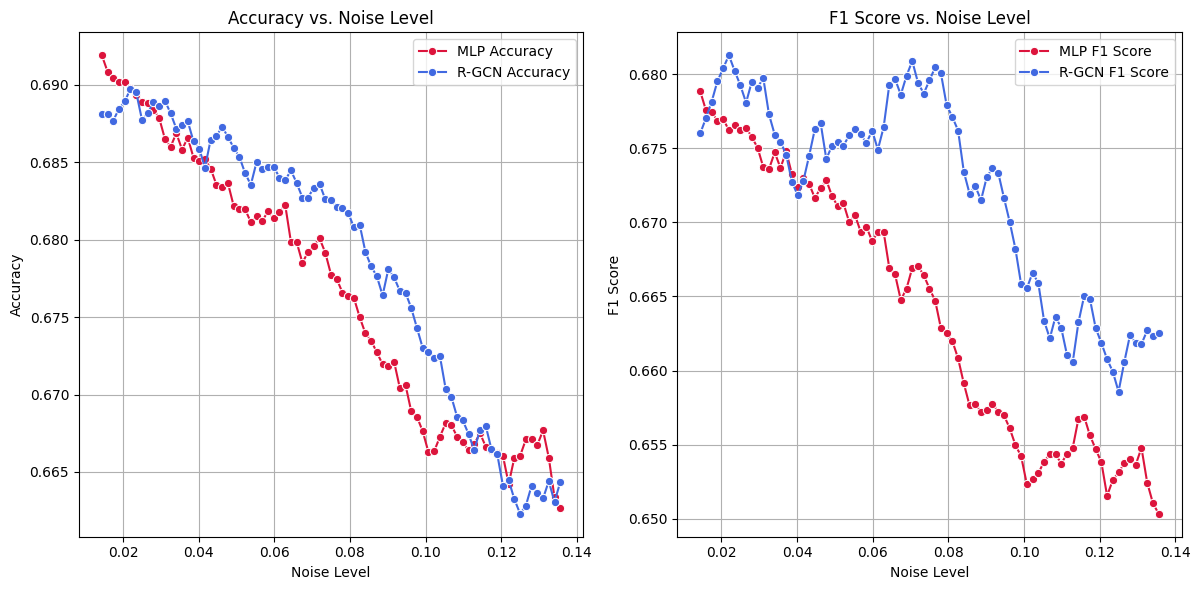

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Reload CSV from most recent experiment output
df = pd.read_csv("noise_experiment_results.csv")


# Plot accuracy and F1 with MLP in red tones, R-GCN in blue tones
plt.figure(figsize=(18, 6))

# Accuracy subplot
plt.subplot(1, 3, 1)
sns.lineplot(data=df, x="noise_level", y="mlp_acc", label="MLP Accuracy", color="crimson", marker="o")
sns.lineplot(data=df, x="noise_level", y="rgcn_acc", label="R-GCN Accuracy", color="royalblue", marker="o")
plt.title("Accuracy vs. Noise Level")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.grid(True)

# F1 Score subplot
plt.subplot(1, 3, 2)
sns.lineplot(data=df, x="noise_level", y="mlp_f1", label="MLP F1 Score", color="crimson", marker="o")
sns.lineplot(data=df, x="noise_level", y="rgcn_f1", label="R-GCN F1 Score", color="royalblue", marker="o")
plt.title("F1 Score vs. Noise Level")
plt.xlabel("Noise Level")
plt.ylabel("F1 Score")
plt.grid(True)



plt.tight_layout()
plt.show()
